# Chapter 4.1

## Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function
from __future__ import unicode_literals

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import tqdm
from hfunc import models
from hfunc import metrics

## Self-created functions

In [3]:
def estimate_node_importance(model, tester_model, layer_sizes, tol_low, tol_high, x, y):
    
    l, a = model.evaluate(x, y, verbose=0, batch_size=256)
    or_weights = model.get_weights()
    weight_len = len(or_weights) - 3
    num_zeros, num_worse, num_important = (0, 0, 0)
    z = []
    wr = []
    imp = []
    amounts = []
    places = []
    for layer, size in enumerate(layer_sizes):
        num_zeros, num_worse, num_important = (0, 0, 0)
        z = []
        wr = []
        imp = []
        for i in range(size):
            w = copy.deepcopy(or_weights)
            w[weight_len - (2*layer+1)][:,i] = 0
            w[weight_len - 2*layer][i] = 0
            tester_model.set_weights(w)
            nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
            change = l - nl
            if change <= tol_high and change >= tol_low:
                num_zeros += 1
                z += [i]
            elif change > 0:
                num_worse += 1
                wr += [i]
            else:
                num_important += 1
                imp += [i]
        amounts.append((num_zeros, num_worse, num_important))
        places.append((z, wr, imp))
    
    return amounts, places

In [4]:
def estimate_node_importance_conv(model, tester_model, dense_layer_sizes, conv_layer_sizes, tol_low, tol_high, x, y):
    
    l, a = model.evaluate(x, y, verbose=0, batch_size=256)
    or_weights = model.get_weights()
    weight_len = len(or_weights) - 3
    conv_len = weight_len - 2 * len(dense_layer_sizes)
    num_zeros, num_worse, num_important = (0, 0, 0)
    z = []
    wr = []
    imp = []
    amounts = []
    places = []
    
    # For-loop over dense layers
    for layer, size in enumerate(dense_layer_sizes):
        num_zeros, num_worse, num_important = (0, 0, 0)
        z = []
        wr = []
        imp = []
        for i in range(size):
            w = copy.deepcopy(or_weights)
            w[weight_len - (2*layer+1)][:,i] = 0
            w[weight_len - 2*layer][i] = 0
            tester_model.set_weights(w)
            nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
            change = l - nl
            if change <= tol_high and change >= tol_low:
                num_zeros += 1
                z += [i]
            elif change > 0:
                num_worse += 1
                wr += [i]
            else:
                num_important += 1
                imp += [i]
        amounts.append((num_zeros, num_worse, num_important))
        places.append((z, wr, imp))
    
    # For-loop over convolutional layers
    for layer, size in enumerate(conv_layer_sizes):
        num_zeros, num_worse, num_important = (0, 0, 0)
        z = []
        wr = []
        imp = []
        for i in range(size):
            w = copy.deepcopy(or_weights)
            w[conv_len - (2*layer+1)][:, :, :, i] = 0
            w[conv_len - 2*layer][i] = 0
            tester_model.set_weights(w)
            nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
            change = l - nl
            if change <= tol_high and change >= tol_low:
                num_zeros += 1
                z += [i]
            elif change > 0:
                num_worse += 1
                wr += [i]
            else:
                num_important += 1
                imp += [i]
        amounts.append((num_zeros, num_worse, num_important))
        places.append((z, wr, imp))

    return amounts, places

In [5]:
def remove_nodes(weights, places):
    weight_len = len(weights) - 3
    for layer, place in enumerate(places):
        for nodes in place[0:2]:
            weights[weight_len - (2*layer+1)][..., nodes] = 0
            weights[weight_len - 2*layer][nodes] = 0
    return weights

## Single-layer ANN

### MNIST

#### Set seed

In [6]:
np.random.seed(2020)

In [7]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [8]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
trials = 50
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)
    tmp_a, tmp_p = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_train, y_train)
    num_rem += [tmp_a[0][0] + tmp_a[0][1]]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [35:59<00:00, 43.19s/it]


In [10]:
NR = pd.Series(num_rem)
NR.to_csv('../../../results/num_removed_ANN_pre_calc_mnist.csv')
NR.describe()

count    50.000000
mean     16.920000
std       7.278259
min       4.000000
25%      12.000000
50%      17.000000
75%      22.000000
max      39.000000
dtype: float64

In [11]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_ANN_pre_calc_mnist.csv')
A.describe()

count    50.000000
mean     -0.015544
std       0.031253
min      -0.197200
25%      -0.016525
50%      -0.004550
75%      -0.001000
max       0.001100
dtype: float64

In [12]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_ANN_pre_calc_mnist.csv')
L.describe()

count    50.000000
mean      0.046542
std       0.092750
min      -0.002456
25%       0.004743
50%       0.014452
75%       0.049401
max       0.591528
dtype: float64

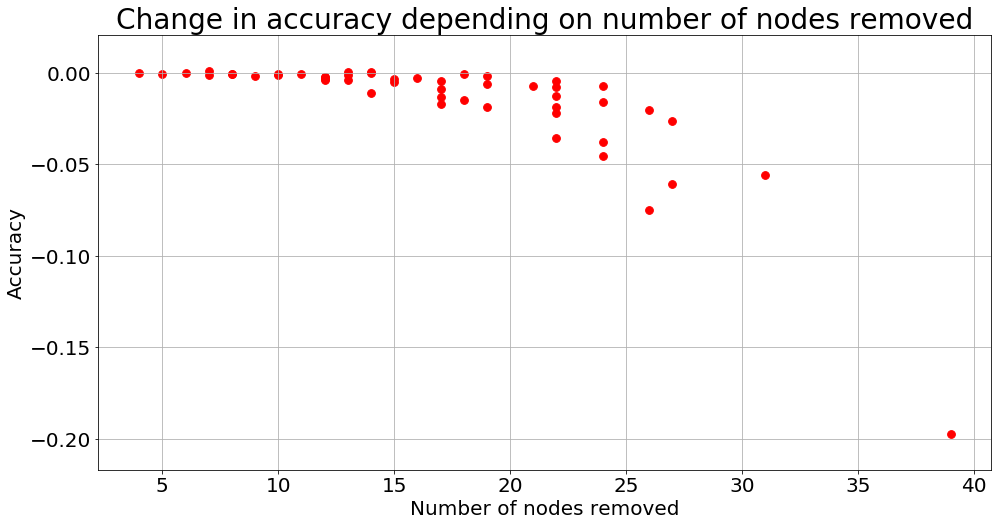

In [13]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_ANN_pre_calc_mnist.png")

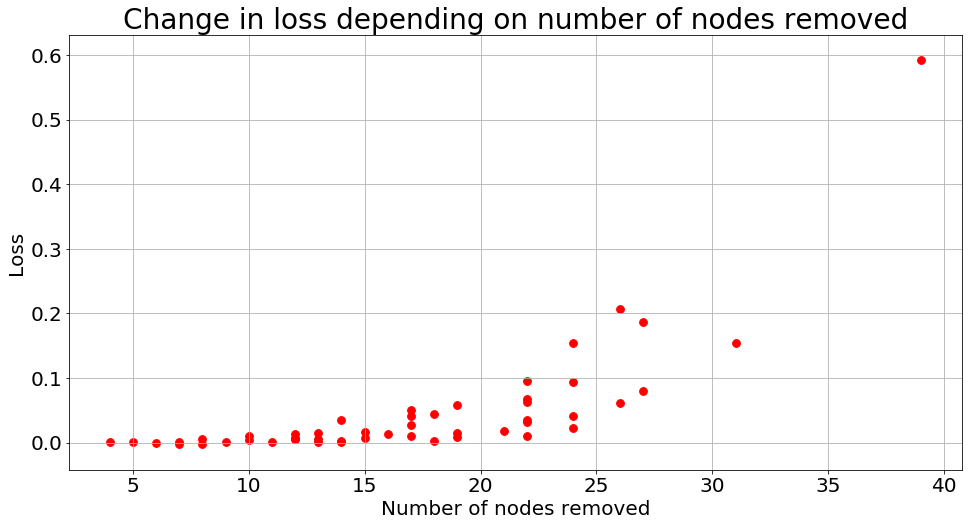

In [14]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_ANN_pre_calc_mnist.png")

### Fashion MNIST

#### Set seed

In [15]:
np.random.seed(2020)

In [16]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [17]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
trials = 50
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)
    tmp_a, tmp_p = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_train, y_train)
    num_rem += [tmp_a[0][0] + tmp_a[0][1]]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [35:51<00:00, 43.02s/it]


In [19]:
NR = pd.Series(num_rem)
NR.to_csv('../../../results/num_removed_ANN_pre_calc_fmnist.csv')
NR.describe()

count    50.00000
mean     32.78000
std       7.18641
min      19.00000
25%      27.25000
50%      34.00000
75%      38.00000
max      46.00000
dtype: float64

In [20]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_ANN_pre_calc_fmnist.csv')
A.describe()

count    50.000000
mean     -0.041164
std       0.032763
min      -0.117300
25%      -0.059325
50%      -0.040750
75%      -0.011350
max       0.002400
dtype: float64

In [21]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_ANN_pre_calc_fmnist.csv')
L.describe()

count    50.000000
mean      0.106201
std       0.086507
min      -0.005111
25%       0.026013
50%       0.109642
75%       0.157102
max       0.372539
dtype: float64

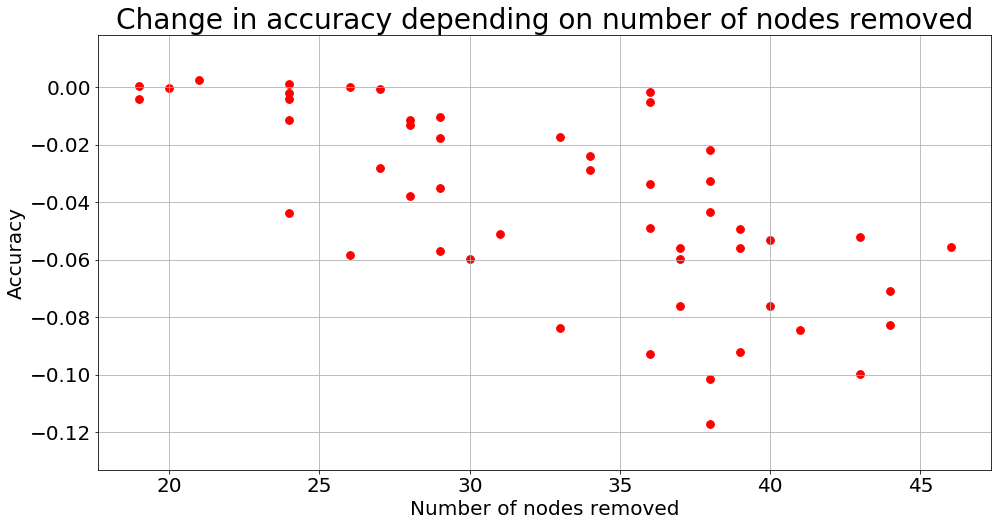

In [22]:
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_ANN_pre_calc_fmnist.png")

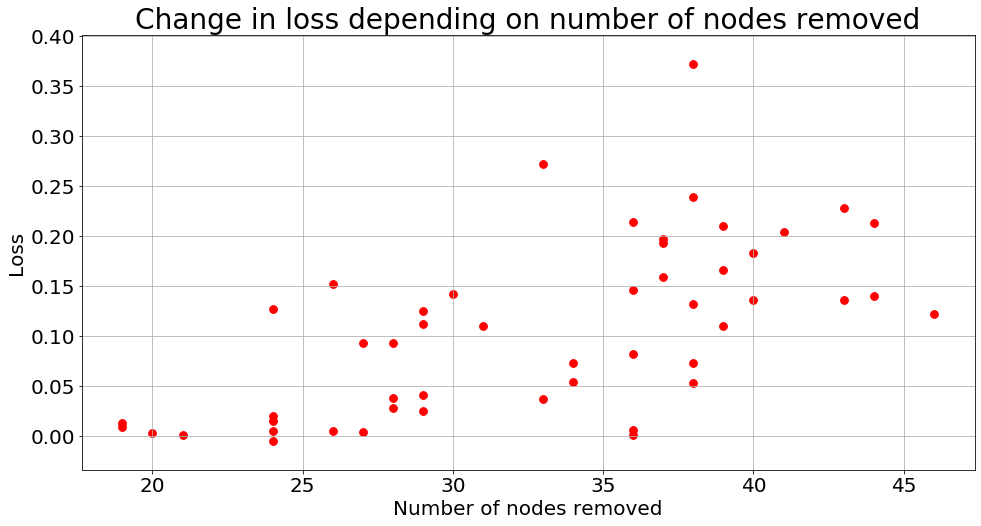

In [23]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_ANN_pre_calc_fmnist.png")

## Multi-layer Perceptron

### MNIST

#### Set seed

In [26]:
np.random.seed(2020)

In [27]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [28]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
trials = 50
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [32, 64, 128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    
    tmp_a, tmp_p = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_train, y_train)
    
    tmp_rem = []
    
    for (nz, nw, _) in tmp_a:
        tmp_rem += [nz + nw]
    
    num_rem += [tmp_rem]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[13]
[17, 27, 28]
[44, 52]
[1, 12, 21, 30, 31, 58]
[4, 106]
[16, 21, 31, 38, 54, 55, 61, 63, 77, 81, 86, 91, 93, 100]


  2%|█▋                                                                                 | 1/50 [01:09<57:08, 69.96s/it]

[0, 19, 30]
[4, 11, 14, 27]
[6, 23]
[11, 14, 15, 21, 22, 24, 31, 42, 43, 47, 50]
[68, 104, 124]
[0, 4, 8, 13, 14, 16, 19, 20, 21, 25, 28, 30, 36, 38, 39, 44, 45, 46, 47, 48, 50, 59, 62, 66, 71, 72, 74, 86, 87, 92, 97, 98, 114, 125, 126]


  4%|███▎                                                                               | 2/50 [02:19<55:49, 69.79s/it]

[30]
[12, 29]
[8, 39]
[0, 4, 9, 15, 28, 30, 32, 42, 43, 55]
[40, 70, 79, 94]
[4, 6, 31, 61, 64, 75, 76, 90, 100, 110, 113, 122, 127]


  6%|████▉                                                                              | 3/50 [03:29<54:40, 69.80s/it]

[20]
[1]
[56]
[6, 9, 11, 13, 21, 29, 33, 34, 40, 43, 45, 58]
[32, 124]
[0, 3, 10, 34, 39, 47, 54, 59, 62, 67, 71, 73, 87, 102, 110, 114, 121, 122, 123]


  8%|██████▋                                                                            | 4/50 [04:38<53:26, 69.71s/it]

[0, 10, 27]
[9, 11]
[47, 59]
[29, 37, 38, 39, 41, 42]
[8, 33]
[12, 13, 17, 61, 77, 88, 96, 104, 106]


 10%|████████▎                                                                          | 5/50 [05:48<52:18, 69.73s/it]

[13, 30, 31]
[14, 27]
[45]
[1, 6, 11, 19, 22, 23, 25, 39, 40, 42, 44, 48, 49, 51, 53, 63]
[9, 28, 92]
[0, 3, 14, 33, 35, 42, 44, 46, 51, 58, 59, 64, 65, 69, 70, 71, 72, 76, 81, 89, 90, 91, 95, 101, 105, 106, 109, 116, 118, 121, 123]


 12%|█████████▉                                                                         | 6/50 [06:57<50:57, 69.50s/it]

[1, 28]
[]
[14, 43]
[17, 19, 27, 31, 36, 50, 55, 56]
[70, 121, 127]
[29, 30, 48, 52, 69, 91, 110, 112, 122, 124]


 14%|███████████▌                                                                       | 7/50 [08:07<49:53, 69.62s/it]

[12, 21]
[7]
[60]
[28, 34, 35]
[50, 72, 79, 119]
[5, 6, 11, 18, 25, 29, 42, 46, 57, 66, 80, 86, 91, 104, 107, 110, 125, 127]


 16%|█████████████▎                                                                     | 8/50 [09:16<48:35, 69.41s/it]

[8, 9]
[10, 27, 29]
[44]
[3, 18, 23, 25, 32, 60]
[74, 101]
[2, 5, 7, 17, 38, 44, 63, 76, 78, 84, 85, 86, 89, 97, 105, 119]


 18%|██████████████▉                                                                    | 9/50 [10:25<47:30, 69.51s/it]

[6]
[9, 25]
[20]
[27, 31]
[124, 127]
[1, 14, 25, 26, 35, 40, 41, 51, 57, 59, 81, 83, 99]


 20%|████████████████▍                                                                 | 10/50 [11:35<46:16, 69.40s/it]

[16, 27, 30]
[]
[11, 18, 36, 58, 62]
[19, 53, 63]
[14, 63, 91]
[4, 30, 36, 45, 67, 82, 114, 119]


 22%|██████████████████                                                                | 11/50 [12:44<45:12, 69.54s/it]

[23]
[11, 20, 27, 31]
[20, 53]
[2, 12, 23, 26, 30, 34, 38, 40, 44, 54, 55, 59, 60, 63]
[]
[0, 1, 3, 26, 30, 35, 39, 40, 44, 57, 62, 72, 74, 85, 87, 113, 114, 119, 125, 127]


 24%|███████████████████▋                                                              | 12/50 [13:54<43:59, 69.47s/it]

[9, 17, 20]
[]
[0, 58]
[23]
[42, 65, 101, 111]
[0]


 26%|█████████████████████▎                                                            | 13/50 [15:04<42:53, 69.56s/it]

[3, 4, 19]
[]
[12]
[3, 5, 8, 27, 31, 33, 43, 44, 51, 52, 60]
[6, 10, 25, 47, 89]
[7, 8, 15, 24, 35, 39, 54, 56, 78, 90, 102, 106, 107, 111, 124]


 28%|██████████████████████▉                                                           | 14/50 [16:13<41:38, 69.40s/it]

[9, 19, 24, 27]
[18]
[47, 49, 59]
[1, 11, 48, 50]
[49, 70, 114]
[7, 8, 15, 28, 39, 40, 52, 80, 92, 96, 99, 109, 111, 122]


 30%|████████████████████████▌                                                         | 15/50 [17:22<40:33, 69.52s/it]

[2]
[3, 25]
[29]
[3, 11, 21, 25, 30, 32, 38, 60]
[18, 19, 23, 51, 115]
[2, 20, 53, 70, 78, 80, 92, 124, 127]


 32%|██████████████████████████▏                                                       | 16/50 [18:32<39:23, 69.50s/it]

[15, 26]
[28]
[34]
[15, 18, 26, 32, 35, 38, 40, 41, 52, 61]
[30, 90, 122]
[4, 7, 16, 21, 22, 27, 34, 40, 46, 48, 53, 66, 68, 70, 78, 85, 91, 95, 98, 99, 103, 104, 105, 107, 108, 110, 111, 113, 114]


 34%|███████████████████████████▉                                                      | 17/50 [19:41<38:14, 69.52s/it]

[17]
[4, 23, 29]
[11]
[14, 43, 52, 56, 62]
[8, 32]
[4, 12, 28, 51, 53, 59, 60, 61, 63, 94, 102, 106, 107, 123]


 36%|█████████████████████████████▌                                                    | 18/50 [20:52<37:10, 69.72s/it]

[22, 26]
[8, 15, 19, 20]
[0, 62]
[2, 15, 18, 20, 26, 33, 35, 37, 38, 39, 41, 51, 56, 60]
[100]
[0, 6, 11, 18, 31, 39, 45, 49, 52, 57, 67, 73, 76, 83, 88, 93, 103, 110, 113, 116, 124]


 38%|███████████████████████████████▏                                                  | 19/50 [22:01<35:57, 69.59s/it]

[1, 6, 23, 29]
[5, 14]
[17, 20, 21, 35, 55]
[0, 4, 13, 14, 15, 22, 47, 49, 53]
[23, 35, 74]
[2, 4, 8, 24, 28, 30, 31, 38, 49, 52, 56, 57, 62, 64, 73, 82, 85, 87, 98, 100, 102, 105, 109, 111, 113, 114, 115, 116, 127]


 40%|████████████████████████████████▊                                                 | 20/50 [23:11<34:50, 69.67s/it]

[0, 23, 31]
[1, 3]
[15, 24]
[25, 41, 61, 63]
[64, 89, 96]
[3, 18, 25, 34, 40, 49, 50, 55, 57, 71, 79, 81, 111, 114, 124]


 42%|██████████████████████████████████▍                                               | 21/50 [24:20<33:37, 69.57s/it]

[9, 21, 30]
[6, 8, 19, 20, 22, 24]
[3, 14, 22]
[10, 15, 16, 20, 42, 52, 54, 59]
[]
[8, 23, 35, 36, 38, 39, 45, 47, 81, 85, 88, 97, 101, 104, 105, 108, 116, 117, 120, 121, 126]


 44%|████████████████████████████████████                                              | 22/50 [25:30<32:30, 69.65s/it]

[]
[1, 3, 8, 21, 26, 27]
[63]
[7, 16, 28, 30, 37, 38, 46, 49, 53]
[]
[2, 5, 10, 20, 25, 39, 43, 44, 46, 49, 52, 56, 62, 65, 71, 86, 98, 110, 112, 117]


 46%|█████████████████████████████████████▋                                            | 23/50 [26:39<31:16, 69.48s/it]

[0, 20, 26]
[8, 24]
[]
[3, 4, 11, 14, 15, 16, 25, 26, 31, 36, 40, 42, 43, 51, 58, 63]
[68, 121]
[0, 7, 15, 19, 20, 21, 32, 36, 43, 46, 50, 53, 56, 57, 70, 79, 82, 95, 104, 105, 112, 120, 127]


 48%|███████████████████████████████████████▎                                          | 24/50 [27:49<30:07, 69.54s/it]

[2, 11, 14, 21]
[15]
[3, 14, 30]
[56]
[79]
[0, 8, 13, 14, 16, 20, 21, 35, 43, 47, 49, 54, 55, 61, 65, 71, 100, 101, 110, 127]


 50%|█████████████████████████████████████████                                         | 25/50 [28:58<28:55, 69.42s/it]

[]
[10, 17, 23, 29]
[9]
[2, 4, 5, 7, 10, 19, 25, 28, 40, 44, 50, 53, 62]
[59, 82]
[8, 10, 12, 19, 24, 26, 36, 45, 46, 47, 55, 61, 64, 70, 76, 81, 90, 94, 110, 119, 120, 123]


 52%|██████████████████████████████████████████▋                                       | 26/50 [30:07<27:47, 69.49s/it]

[9, 24, 28]
[3, 5]
[10]
[7, 19, 23, 34]
[88, 92]
[82, 106, 114]


 54%|████████████████████████████████████████████▎                                     | 27/50 [31:16<26:32, 69.22s/it]

[4, 31]
[2]
[43]
[3, 9, 10, 11, 13, 15, 16, 19, 25, 29, 36, 39, 47, 50, 53, 58]
[26, 35, 47, 71, 88, 92, 102]
[3, 8, 10, 11, 14, 20, 22, 29, 42, 49, 61, 75, 80, 84, 117, 123, 125]


 56%|█████████████████████████████████████████████▉                                    | 28/50 [32:26<25:27, 69.41s/it]

[18]
[1, 7, 20, 22, 27]
[18, 25]
[0, 9, 11, 17, 36, 40, 44, 53, 55]
[95, 97]
[0, 13, 21, 31, 40, 66, 68, 69, 82, 94, 102, 106, 121, 122, 124]


 58%|███████████████████████████████████████████████▌                                  | 29/50 [33:35<24:15, 69.29s/it]

[1, 11]
[22]
[29, 37]
[3, 11, 28, 30, 35, 42, 45, 46, 48, 51]
[6, 26, 54, 85]
[4, 14, 20, 27, 34, 35, 37, 38, 44, 48, 56, 74, 76, 78, 89, 92, 104, 107, 108, 112, 115, 125, 127]


 60%|█████████████████████████████████████████████████▏                                | 30/50 [34:45<23:07, 69.38s/it]

[18, 23]
[0, 31]
[35]
[8, 14, 15, 19, 21, 25, 29, 36, 42, 44, 54, 55, 62]
[118]
[6, 13, 14, 16, 18, 21, 26, 28, 35, 36, 64, 65, 76, 81, 83, 90, 97, 102, 115, 119, 120, 123, 127]


 62%|██████████████████████████████████████████████████▊                               | 31/50 [35:53<21:55, 69.23s/it]

[25]
[0, 14]
[4, 52]
[8, 12, 14, 23, 27, 32, 39, 43, 44, 53, 63]
[]
[5, 6, 23, 25, 33, 53, 54, 68, 80, 82, 85, 103, 114, 116, 127]


 64%|████████████████████████████████████████████████████▍                             | 32/50 [37:03<20:46, 69.27s/it]

[19, 24]
[]
[]
[7, 13, 24, 25, 34, 38, 51, 61]
[11, 21, 79, 114]
[3, 8, 16, 22, 23, 24, 38, 48, 53, 56, 61, 72, 77, 82, 84, 85, 92, 97, 98, 101, 102, 124]


 66%|██████████████████████████████████████████████████████                            | 33/50 [38:12<19:38, 69.30s/it]

[4, 17, 28]
[]
[17, 27, 54, 63]
[31, 44]
[69, 70, 80, 107, 123, 124]
[6, 15, 18, 26, 29, 44, 61, 87, 89, 95, 127]


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [39:21<18:27, 69.25s/it]

[]
[0, 22, 31]
[62]
[12, 14, 15, 16, 27, 33, 39, 55, 56, 61]
[1, 68, 78, 93, 101, 108, 120, 126]
[19, 24, 43, 49, 60, 61, 63, 64, 66, 83, 85, 113, 118]


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [40:31<17:19, 69.32s/it]

[14, 26]
[17]
[]
[15, 16, 19, 27, 29, 36, 54]
[]
[0, 9, 10, 12, 14, 16, 20, 53, 69, 109, 118, 124]


 72%|███████████████████████████████████████████████████████████                       | 36/50 [41:39<16:07, 69.14s/it]

[7, 17]
[10, 24]
[0, 11, 29, 33, 44]
[17, 53]
[]
[3, 12, 14, 20, 22, 41, 50, 51, 55, 58, 60, 63, 71, 85, 91, 97, 109, 111]


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [42:50<15:03, 69.47s/it]

[29]
[3, 5, 8, 10, 18, 20, 26]
[2, 25, 52]
[1, 14, 21, 23, 28, 37, 41, 44, 46, 48, 49, 50, 53, 55, 57, 58]
[34, 43]
[1, 2, 3, 7, 12, 15, 18, 26, 27, 31, 32, 35, 45, 46, 47, 49, 55, 65, 70, 76, 77, 80, 83, 86, 90, 99, 101, 102, 106, 108, 110, 111, 112, 118, 120, 121, 127]


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [43:59<13:51, 69.32s/it]

[2, 6, 19]
[3, 8, 9, 24, 25]
[]
[7, 9, 10, 12, 16, 25, 33, 36, 53, 57, 62]
[55, 120, 123]
[9, 20, 21, 23, 32, 33, 38, 43, 46, 51, 59, 67, 71, 92, 113, 119, 127]


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [45:09<12:44, 69.48s/it]

[24, 25]
[12, 21, 29]
[1, 3, 12, 13, 50]
[6, 9, 22, 38, 41, 54, 63]
[2, 7, 54]
[14, 18, 24, 35, 39, 42, 43, 50, 55, 57, 61, 63, 68, 72, 79, 91, 93, 94, 101, 102, 104, 112, 116, 117, 120]


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [46:18<11:34, 69.42s/it]

[7]
[0]
[3, 21, 44]
[17, 31, 47, 58, 61]
[48, 72, 103, 125]
[7, 20, 46, 66, 67, 89, 93, 98, 113, 115]


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [47:27<10:24, 69.36s/it]

[2, 16]
[6, 13, 19, 23, 27]
[20, 58]
[1, 5, 8, 10, 24, 32, 35, 37, 38, 40, 42, 46, 47, 49, 54, 62]
[34, 48, 63, 84, 106]
[0, 1, 8, 31, 35, 37, 38, 47, 51, 54, 60, 61, 62, 65, 67, 72, 75, 76, 77, 80, 81, 82, 83, 86, 90, 101, 118, 119, 121, 124]


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [48:37<09:15, 69.49s/it]

[2, 12, 28]
[17, 20]
[4, 22, 42, 44]
[10, 12, 17, 23, 29, 33, 48, 53]
[9, 16, 20, 113, 118]
[7, 25, 32, 41, 43, 50, 55, 57, 74, 75, 82, 110, 116, 119, 120, 122]


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [49:46<08:06, 69.51s/it]

[21]
[16]
[3, 22, 34, 43]
[0, 9, 15, 25, 41, 57]
[26, 77]
[2, 34, 41, 42, 44, 45, 48, 54, 56, 61, 62, 65, 71, 94, 95, 109, 122]


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [50:56<06:57, 69.65s/it]

[22]
[18, 29]
[]
[2, 6, 13, 14, 42, 50, 55, 63]
[43, 69]
[12, 13, 21, 28, 33, 80, 83, 97, 101, 108, 120]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [52:05<05:47, 69.47s/it]

[20, 31]
[15, 24, 25, 26, 27]
[5]
[19, 20, 24, 26, 28, 29, 32, 34, 43, 51, 53, 58]
[2, 37, 38, 59, 61]
[0, 9, 17, 20, 26, 31, 41, 51, 52, 70, 83, 87, 88, 92, 93, 100, 102, 110, 111, 114, 123, 124]


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [53:16<04:38, 69.74s/it]

[29, 31]
[1, 2, 19]
[]
[7, 9, 10, 27, 28, 43, 55]
[49, 70, 91]
[2, 6, 10, 20, 31, 37, 38, 43, 52, 65, 75, 80, 83, 89, 90, 115, 121, 126]


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [54:25<03:28, 69.56s/it]

[4, 23, 28]
[27]
[35, 37, 46, 62]
[7, 8, 17, 18, 26, 41, 43, 48, 58]
[]
[0, 4, 5, 23, 26, 30, 31, 32, 38, 43, 52, 78, 93]


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [55:35<02:19, 69.73s/it]

[14, 31]
[1, 10, 19, 26]
[]
[1, 6, 10, 16, 24, 25, 29, 34, 38, 43, 44, 47, 53, 62]
[5, 24, 65]
[0, 6, 9, 10, 15, 29, 33, 40, 55, 58, 61, 64, 82, 84, 87, 88, 92, 93, 99, 107, 111, 115, 122, 123]


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [56:44<01:09, 69.62s/it]

[1, 20, 24, 31]
[13, 29]
[8, 22]
[1, 2, 3, 5, 10, 50, 55, 56, 58]
[1, 25, 29, 57, 66, 68, 92, 120]
[0, 2, 6, 9, 18, 21, 30, 32, 42, 49, 54, 74, 79, 82, 83, 88, 98, 103, 105, 106, 108, 118, 123]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [57:54<00:00, 69.48s/it]


In [30]:
NR = pd.DataFrame(num_rem, columns=["Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_MLP_pre_calc_mnist.csv')
NR.describe()

,Layer 3,Layer 2,Layer 1
count,50.000000,50.000000,50.000000
mean,4.420000,10.500000,20.740000
std,1.727213,4.006372,7.623299
min,2.000000,3.000000,5.000000
25%,3.000000,7.250000,16.000000
50%,4.000000,11.000000,20.000000
75%,5.000000,13.000000,24.750000
max,9.000000,19.000000,39.000000


In [31]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_MLP_pre_calc_mnist.csv')
A.describe()

count    50.000000
mean     -0.083124
std       0.070614
min      -0.243400
25%      -0.126500
50%      -0.070750
75%      -0.016600
max       0.000100
dtype: float64

In [32]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_MLP_pre_calc_mnist.csv')
L.describe()

count    50.000000
mean      0.268865
std       0.257580
min      -0.001439
25%       0.049025
50%       0.217474
75%       0.428603
max       1.006135
dtype: float64

In [33]:
num_rem = [sum(rem) for rem in num_rem]

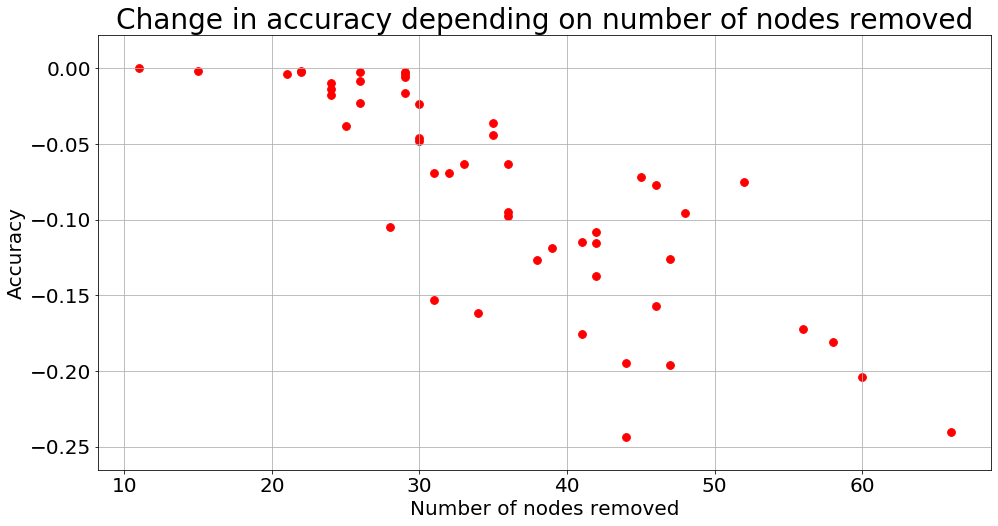

In [34]:
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_MLP_pre_calc_mnist.png")

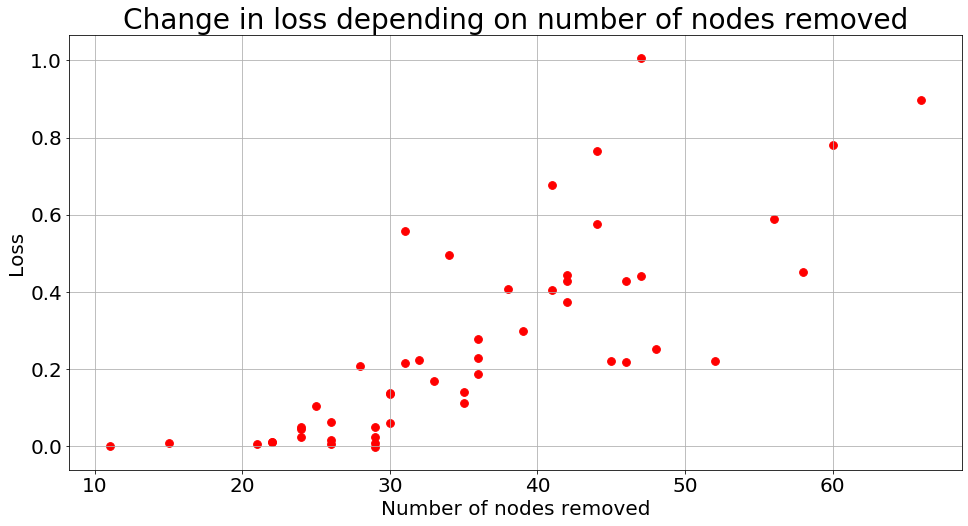

In [35]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_MLP_pre_calc_mnist.png")

### Fashion MNIST

#### Set seed

In [40]:
np.random.seed(2020)

In [41]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [42]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [43]:
trials = 50
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [32, 64, 128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    
    tmp_a, tmp_p = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_train, y_train)
    tmp_rem = []
    
    for (nz, nw, _) in tmp_a:
        tmp_rem += [nz + nw]
    
    num_rem += [tmp_rem]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[0, 9]
[14, 23]
[5, 46, 52, 54, 60]
[11, 26, 30, 31, 33, 41, 58, 59]
[2, 13, 16, 31, 39, 46, 49, 51, 91, 111, 125, 126]
[1, 12, 18, 22, 28, 40, 44, 45, 48, 52, 58, 59, 60, 61, 72, 75, 82, 84, 89, 96, 97, 98, 99, 110]


  2%|█▋                                                                                 | 1/50 [01:09<57:01, 69.83s/it]

[4, 17, 18, 20, 22]
[]
[44, 52]
[14, 18, 21, 24, 28, 32, 34, 38, 41, 56, 57, 58, 63]
[0, 1, 11, 16, 36, 44, 57, 59, 72, 78, 83, 85, 109, 124, 126]
[2, 13, 19, 35, 40, 50, 54, 86, 117, 120]


  4%|███▎                                                                               | 2/50 [02:19<55:52, 69.84s/it]

[8, 27]
[3, 13, 23, 26, 31]
[5, 8, 14, 22, 33, 36, 39, 47, 50]
[3, 6, 9, 10, 11, 12, 16, 18, 23, 30, 31, 44, 59]
[0, 21, 22, 27, 36, 52, 54, 55, 68, 69, 71, 77, 78, 81, 102, 107, 115, 116, 123, 127]
[9, 10, 13, 14, 26, 28, 32, 37, 45, 51, 59, 61, 65, 66, 72, 82, 85, 86, 90, 103, 104, 106, 108, 114, 122]


  6%|████▉                                                                              | 3/50 [03:28<54:31, 69.60s/it]

[]
[2, 5, 6, 9, 16, 26]
[17, 27, 35]
[1, 7, 13, 21, 28, 37, 38, 40, 41, 42, 46]
[4, 5, 18, 23, 28, 32, 36, 39, 40, 65, 86, 87, 95, 96, 98, 121, 124]
[2, 7, 9, 19, 25, 38, 51, 54, 55, 59, 63, 72, 83, 85, 89, 92, 94, 99, 100, 101]


  8%|██████▋                                                                            | 4/50 [04:38<53:17, 69.50s/it]

[1, 31]
[3, 17, 23]
[15]
[4, 8, 12, 19, 20, 29, 31, 35, 40, 45, 49, 55, 61, 62, 63]
[2, 10, 13, 14, 16, 17, 37, 43, 71, 76, 77, 101, 108, 112, 115, 127]
[1, 11, 18, 24, 27, 29, 42, 57, 61, 73, 87, 90, 98, 102, 124]


 10%|████████▎                                                                          | 5/50 [05:47<52:12, 69.61s/it]

[1, 16, 21, 31]
[]
[18, 27, 37, 46]
[0, 8, 15, 16, 26, 31, 32, 40, 55, 60]
[3, 10, 12, 16, 28, 29, 33, 40, 51, 53, 57, 79, 103, 110, 121]
[30, 32, 42, 50, 67, 69, 71, 81, 101, 108, 119, 125, 127]


 12%|█████████▉                                                                         | 6/50 [06:56<50:52, 69.37s/it]

[0, 2, 6, 16, 21]
[26]
[1, 4, 7, 12, 17, 27, 38]
[9, 26, 33, 40, 41, 44]
[0, 9, 21, 22, 31, 32, 39, 57, 63, 76, 93, 110, 125]
[12, 41, 42, 55, 74, 78]


 14%|███████████▌                                                                       | 7/50 [08:07<49:56, 69.67s/it]

[14, 22]
[3, 6, 12, 13, 18]
[11, 38, 43, 51]
[1, 4, 5, 8, 21, 26, 33, 41, 49, 55, 58, 59]
[1, 5, 12, 13, 26, 27, 37, 45, 60, 74, 88, 89, 93, 97, 104, 106, 109, 112, 115, 117]
[2, 4, 11, 18, 20, 21, 22, 33, 35, 43, 47, 48, 54, 66, 68, 70, 78, 79, 87, 91, 92, 94, 100, 101, 108, 121, 123]


 16%|█████████████▎                                                                     | 8/50 [09:16<48:37, 69.46s/it]

[0, 16]
[6, 18, 19, 21, 23, 28, 31]
[1, 5, 13, 34, 40]
[0, 2, 7, 9, 10, 17, 20, 23, 25, 26, 27, 30, 33, 42, 48, 57, 60, 63]
[5, 14, 15, 22, 36, 41, 55, 61, 65, 71, 82, 85, 87, 90, 93, 97, 101, 113, 123, 127]
[7, 8, 9, 13, 18, 19, 21, 29, 30, 31, 44, 47, 53, 78, 80, 88, 95, 100, 106, 110, 111, 119, 120, 122]


 18%|██████████████▉                                                                    | 9/50 [10:25<47:22, 69.33s/it]

[3, 8, 14, 22, 23]
[9]
[3]
[4, 13, 20, 34, 49, 50, 52, 54, 63]
[6, 8, 23, 27, 41, 46, 93, 102, 107, 116, 125]
[22, 24, 32, 37, 45, 65, 69, 74, 78, 80, 82]


 20%|████████████████▍                                                                 | 10/50 [11:35<46:24, 69.60s/it]

[2, 9]
[8, 11, 12, 25]
[4]
[2, 3, 8, 9, 13, 15, 18, 20, 23, 26, 29, 39, 41, 42, 45, 48, 50, 54, 55, 60]
[0, 7, 23, 36, 38, 40, 42, 50, 65, 71, 72, 76, 81, 84, 91, 103, 110, 111, 119, 120, 122]
[13, 14, 18, 20, 21, 24, 46, 55, 80, 82, 83, 85, 97, 106, 109, 114]


 22%|██████████████████                                                                | 11/50 [12:44<45:06, 69.41s/it]

[19]
[5, 15, 17, 18, 20, 21, 23]
[45, 49, 50, 58]
[0, 2, 3, 4, 9, 11, 12, 14, 15, 17, 30, 35, 37, 39, 40, 56, 57, 60]
[7, 10, 14, 19, 26, 34, 50, 51, 61, 63, 91, 97, 98, 101, 120]
[4, 13, 17, 20, 23, 25, 31, 37, 39, 42, 44, 46, 48, 52, 58, 64, 68, 69, 71, 83, 92, 100, 102, 106, 107, 109, 110, 111, 112, 115, 116, 121, 122, 125, 126]


 24%|███████████████████▋                                                              | 12/50 [13:54<44:03, 69.56s/it]

[2, 7, 30]
[4, 6, 14, 17]
[18, 22, 42, 52]
[0, 6, 16, 19, 21, 26, 27, 31, 33, 40, 45, 54, 55, 56]
[3, 7, 8, 15, 16, 17, 18, 27, 36, 48, 55, 56, 57, 61, 71, 82, 88, 89, 94, 99, 106, 110, 126, 127]
[0, 9, 23, 30, 37, 60, 62, 69, 74, 85, 87, 93, 96, 104, 105, 122]


 26%|█████████████████████▎                                                            | 13/50 [15:03<42:50, 69.47s/it]

[11, 12, 15, 17]
[19, 23]
[0, 13, 30, 48, 55]
[6, 8, 14, 19, 20, 23, 33, 38, 41, 42, 45, 49, 51, 60]
[7, 11, 15, 18, 20, 27, 55, 67, 76, 87, 93, 108, 120, 121, 124]
[5, 12, 16, 28, 30, 31, 38, 45, 48, 51, 62, 68, 81, 91, 94, 95, 109, 115, 117]


 28%|██████████████████████▉                                                           | 14/50 [16:13<41:47, 69.66s/it]

[1, 24, 25]
[4, 6, 21]
[24, 25, 27, 44, 56]
[1, 7, 8, 20, 39]
[0, 3, 5, 16, 28, 39, 47, 49, 53, 67, 70, 74, 75, 82, 92, 93, 97, 104, 106, 111, 112]
[19, 26, 27, 32, 78, 103]


 30%|████████████████████████▌                                                         | 15/50 [17:23<40:39, 69.70s/it]

[1, 2, 12]
[17, 23, 27]
[17, 42, 48, 50]
[7, 9, 11, 43, 52, 53]
[21, 23, 32, 38, 44, 46, 54, 64, 94, 111, 116, 121, 123]
[5, 11, 12, 34, 41, 42, 51, 55, 60, 75, 87, 88, 95, 98, 120]


 32%|██████████████████████████▏                                                       | 16/50 [18:32<39:26, 69.61s/it]

[11, 22]
[1, 8, 13, 27, 29, 30]
[13, 16]
[14, 22, 24, 25, 35, 37, 45, 46, 52, 62, 63]
[0, 1, 6, 8, 9, 33, 35, 37, 46, 50, 56, 61, 64, 78, 82, 85, 87, 92, 93, 104, 114, 116]
[16, 17, 20, 21, 27, 39, 48, 58, 65, 70, 72, 76, 86, 97, 117, 120, 123]


 34%|███████████████████████████▉                                                      | 17/50 [19:43<38:26, 69.90s/it]

[16, 18, 24, 30]
[1, 28]
[38, 40, 53, 54, 62, 63]
[28, 37, 60]
[2, 19, 22, 30, 34, 40, 41, 43, 44, 46, 57, 61, 63, 68, 89, 90, 91, 96, 100, 122]
[15, 24, 26, 31, 52, 62, 70, 81, 85, 95, 107, 119, 125]


 36%|█████████████████████████████▌                                                    | 18/50 [20:52<37:11, 69.74s/it]

[4, 25, 26, 27]
[19, 21]
[21, 38, 40, 56, 57]
[3, 4, 15, 32, 35, 43, 54]
[6, 15, 19, 30, 33, 36, 43, 46, 65, 71, 77, 85, 97, 114, 116, 127]
[45, 60, 62, 78, 82, 83, 93, 96, 102, 109, 112, 120, 122, 125]


 38%|███████████████████████████████▏                                                  | 19/50 [22:02<36:04, 69.83s/it]

[0, 16]
[12, 19, 24]
[12, 17, 20, 34, 39]
[4, 9, 13, 18, 28, 30, 31, 42, 43, 45, 52, 54, 58, 60]
[4, 6, 8, 13, 32, 36, 58, 61, 62, 78, 81, 97, 98, 106, 114, 118, 127]
[2, 5, 10, 24, 35, 37, 41, 43, 45, 50, 52, 54, 63, 66, 67, 70, 73, 88, 92, 100, 102, 104, 108, 120, 126]


 40%|████████████████████████████████▊                                                 | 20/50 [23:12<34:55, 69.85s/it]

[4, 7, 11, 13, 26]
[15]
[15, 53, 55]
[7, 27]
[2, 6, 17, 22, 28, 29, 34, 36, 40, 49, 52, 53, 56, 75, 81, 87, 88, 95, 99, 103]
[48, 96, 118]


 42%|██████████████████████████████████▍                                               | 21/50 [24:22<33:42, 69.73s/it]

[12, 16, 26]
[4, 14, 27]
[32]
[7, 12, 20, 23, 29, 33, 41, 42, 53, 54, 63]
[3, 5, 17, 22, 26, 28, 55, 59, 67, 72, 81, 88, 93, 101, 102, 109, 110, 115, 124]
[8, 9, 11, 31, 37, 51, 53, 58, 60, 66, 74, 83, 96, 97, 103, 104, 107, 112, 113, 119, 122]


 44%|████████████████████████████████████                                              | 22/50 [25:32<32:39, 69.98s/it]

[]
[0, 4, 5, 10, 14, 19, 22, 24, 28]
[47, 50, 62]
[1, 7, 12, 15, 23, 27, 31, 34, 35, 39, 41, 44, 49, 51, 53, 54, 57, 58]
[10, 19, 27, 52, 66, 67, 100, 111, 117]
[1, 4, 5, 29, 31, 32, 35, 40, 51, 53, 55, 56, 61, 63, 70, 73, 77, 82, 97, 105, 115, 116, 120, 126]


 46%|█████████████████████████████████████▋                                            | 23/50 [26:42<31:25, 69.84s/it]

[12, 24]
[1, 2, 5, 11, 14, 30]
[14, 15, 20]
[0, 31, 33, 35, 41, 42, 52]
[8, 11, 13, 14, 20, 22, 33, 42, 58, 75, 80, 95, 96, 102, 108, 117, 121]
[7, 10, 23, 25, 27, 28, 29, 32, 38, 39, 59, 67, 69, 81, 82, 86, 94, 101, 107, 109, 112, 119, 120]


 48%|███████████████████████████████████████▎                                          | 24/50 [27:51<30:15, 69.83s/it]

[]
[5, 6, 9, 10, 14, 15, 18, 27, 28, 30, 31]
[0, 27, 32, 40, 55]
[3, 5, 9, 10, 11, 12, 14, 16, 19, 20, 22, 23, 26, 33, 36, 38, 42, 43, 51, 53, 62, 63]
[12, 17, 21, 33, 34, 41, 53, 55, 57, 59, 79, 90, 98, 110, 117, 123]
[0, 1, 3, 8, 9, 16, 30, 31, 32, 36, 37, 39, 40, 44, 49, 67, 73, 76, 81, 82, 83, 85, 87, 89, 92, 96, 99, 102, 104, 106, 114, 121, 127]


 50%|█████████████████████████████████████████                                         | 25/50 [29:02<29:07, 69.91s/it]

[16, 23]
[12, 15, 25]
[1, 16, 56, 63]
[0, 17, 19, 25, 31, 36, 44, 47, 53, 54]
[0, 3, 22, 27, 55, 59, 60, 64, 66, 75, 87, 91, 103, 106, 114, 119]
[5, 9, 11, 12, 21, 23, 24, 28, 29, 41, 42, 44, 45, 48, 62, 81, 82, 98, 108, 115, 116, 120]


 52%|██████████████████████████████████████████▋                                       | 26/50 [30:11<27:52, 69.71s/it]

[11, 17, 24, 29, 30]
[5]
[7, 11, 27, 32, 50]
[0, 5, 13, 16, 19, 21, 22, 25, 30, 34, 38, 43, 51, 60, 61]
[3, 4, 14, 16, 18, 22, 28, 56, 62, 68, 70, 76, 96, 100, 109, 121, 126]
[1, 8, 13, 27, 30, 31, 36, 37, 52, 58, 67, 88, 90, 91, 99, 101, 105, 117]


 54%|████████████████████████████████████████████▎                                     | 27/50 [31:21<26:47, 69.91s/it]

[0, 2, 4, 11]
[7, 15, 20]
[15, 27]
[3, 5, 9, 17, 20, 44, 50, 62]
[5, 7, 11, 15, 27, 28, 29, 39, 40, 42, 48, 63, 64, 65, 68, 69, 73, 79, 91, 97, 106, 109]
[17, 31, 43, 44, 45, 46, 62, 71, 74, 78, 80, 82, 95, 110, 112, 113, 115]


 56%|█████████████████████████████████████████████▉                                    | 28/50 [32:31<25:35, 69.81s/it]

[9, 13, 21, 25]
[1]
[7, 11, 13, 49, 63]
[0, 3, 5, 6, 18, 25, 27, 45, 56, 61]
[0, 3, 6, 9, 17, 22, 23, 34, 43, 44, 48, 70, 78, 86, 110, 114, 118, 120, 121]
[7, 12, 13, 21, 30, 36, 45, 49, 59, 72, 75, 80, 82, 85, 95, 96, 100, 107, 125]


 58%|███████████████████████████████████████████████▌                                  | 29/50 [33:40<24:23, 69.70s/it]

[14, 17, 19]
[3, 8]
[2, 22, 38, 55]
[48, 51, 56, 59]
[3, 8, 9, 16, 29, 50, 61, 87, 109, 112, 116, 122]
[0, 7, 19, 21, 24, 26, 37, 41, 44, 46, 55, 57, 67, 84, 85, 100, 105, 111, 118]


 60%|█████████████████████████████████████████████████▏                                | 30/50 [34:50<23:17, 69.86s/it]

[]
[4, 6, 10, 16, 18]
[26, 60]
[3, 4, 8, 10, 20, 21, 32, 35, 39, 40, 43, 49, 52, 55, 63]
[15, 22, 30, 33, 35, 42, 43, 44, 49, 55, 57, 61, 69, 73, 74, 102, 107, 114, 116, 118, 121, 126, 127]
[2, 3, 6, 7, 9, 11, 18, 23, 29, 31, 34, 36, 41, 46, 56, 58, 75, 84, 85, 86, 89, 104, 108, 110, 124]


 62%|██████████████████████████████████████████████████▊                               | 31/50 [36:00<22:04, 69.73s/it]

[1, 7, 12]
[3, 4, 15, 18, 21]
[8, 18, 28, 29, 30, 32, 52]
[3, 4, 5, 16, 21, 38, 43, 46, 55, 59]
[2, 5, 22, 25, 28, 40, 46, 47, 49, 63, 76, 79, 99, 100, 104]
[1, 4, 12, 16, 38, 41, 43, 54, 61, 65, 107, 108, 117]


 64%|████████████████████████████████████████████████████▍                             | 32/50 [37:10<20:59, 69.98s/it]

[11, 15, 30]
[5, 8, 10, 19, 27]
[62]
[7, 10, 16, 17, 18, 22, 23, 24, 26, 50, 51, 52, 53]
[16, 23, 26, 27, 29, 42, 54, 59, 66, 123, 124]
[4, 8, 11, 19, 20, 24, 35, 41, 46, 47, 58, 60, 63, 65, 68, 83, 104, 106, 108, 109, 113, 120, 127]


 66%|██████████████████████████████████████████████████████                            | 33/50 [38:20<19:46, 69.78s/it]

[12]
[2, 3]
[0, 16, 35, 44]
[1, 2, 8, 9, 15, 31, 37, 38, 45, 49]
[1, 4, 14, 34, 35, 41, 43, 51, 63, 70, 79, 80, 91, 98, 100, 103, 107, 110, 113, 117, 122]
[7, 19, 37, 44, 52, 56, 81, 83, 86, 89, 99, 101, 102, 123]


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [39:29<18:34, 69.66s/it]

[4, 5, 9, 11, 13]
[3, 6]
[3, 25, 51, 57]
[5, 7, 21, 33, 38, 40, 45, 47, 50, 53, 60]
[0, 4, 8, 17, 27, 46, 56, 66, 77, 84, 85, 86, 99, 104, 110, 119, 120, 126, 127]
[3, 9, 16, 42, 47, 48, 50, 51, 63, 64, 76, 98, 105, 116, 117, 123]


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [40:39<17:26, 69.78s/it]

[6, 10, 20, 21]
[0, 1, 7, 8, 11, 14, 24, 28]
[2, 20, 46, 48, 61]
[1, 8, 9, 12, 15, 18, 23, 24, 27, 31, 36, 40, 42, 43, 44, 45, 49, 53, 56]
[6, 7, 29, 33, 36, 44, 45, 47, 52, 54, 61, 74, 88, 89, 95, 97, 108, 110, 114, 115, 120]
[9, 11, 16, 31, 39, 42, 43, 46, 49, 60, 69, 72, 75, 87, 92, 101, 103, 105, 106, 107, 112, 113, 119, 121, 126, 127]


 72%|███████████████████████████████████████████████████████████                       | 36/50 [41:48<16:13, 69.56s/it]

[13, 21, 24]
[5, 18, 25, 26]
[52]
[3, 9, 10, 12, 16, 18, 20, 23, 26, 28, 29, 32, 36, 46, 48, 50, 53, 60]
[2, 7, 11, 42, 44, 51, 66, 72, 79, 89, 91, 101, 105, 112, 124, 127]
[1, 14, 17, 31, 33, 34, 35, 46, 47, 53, 67, 70, 74, 82, 84, 108, 120]


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [42:59<15:08, 69.90s/it]

[3, 16, 29]
[14, 15, 20, 26]
[14, 17, 29, 31, 34, 37]
[3, 8, 9, 20, 22, 23, 24, 27, 36, 42, 43, 47, 48, 50, 55, 61]
[4, 5, 19, 20, 25, 29, 35, 38, 41, 57, 60, 67, 92, 95, 106, 117, 127]
[0, 6, 18, 22, 32, 42, 44, 53, 56, 59, 61, 62, 64, 66, 68, 69, 70, 72, 75, 78, 82, 88, 97, 99, 109, 111, 115, 116, 118, 120, 124, 126]


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [44:08<13:54, 69.56s/it]

[13, 18, 23, 28, 30]
[24, 27, 29]
[2, 3, 5, 44, 45, 52]
[14, 33, 34, 49]
[4, 5, 8, 10, 13, 22, 30, 33, 46, 48, 62, 63, 67, 75, 77, 83, 87, 89, 92, 109, 121, 125]
[1, 6, 7, 14, 35, 37, 41, 59, 78, 102, 104, 107, 119, 123]


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [45:17<12:44, 69.53s/it]

[]
[1, 4, 5, 6, 11, 18, 21, 24, 29, 30]
[17, 28, 32]
[0, 3, 8, 14, 15, 19, 20, 21, 22, 23, 25, 26, 29, 34, 36, 39, 41, 42, 44, 49, 51, 53, 55, 59, 61]
[8, 19, 26, 30, 51, 63, 90, 91, 97, 98, 101, 103]
[0, 3, 13, 21, 22, 42, 45, 46, 47, 52, 57, 58, 60, 65, 69, 70, 82, 83, 84, 89, 96, 99, 100, 104, 106, 117, 118, 119, 120, 123, 127]


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [46:27<11:37, 69.70s/it]

[4, 15, 19, 20, 22]
[6, 13]
[1, 4, 25, 27, 30, 34, 35, 47, 51]
[8, 24, 36, 40, 43]
[5, 8, 15, 18, 23, 26, 30, 32, 40, 43, 46, 49, 59, 69, 80, 84, 93, 95, 97, 100, 103, 104, 105, 106, 114, 123]
[52, 75, 85, 110, 118, 120]


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [47:37<10:26, 69.60s/it]

[4, 21, 25, 30]
[1, 10, 24]
[0, 25, 53, 54]
[12, 15, 17, 20, 23, 27, 30, 33, 34, 36, 40, 42, 52, 59, 61, 62]
[4, 12, 34, 35, 37, 48, 52, 54, 60, 68, 69, 95, 104, 112]
[2, 8, 9, 13, 16, 23, 24, 39, 44, 53, 77, 83, 89, 92, 96, 100, 108, 114, 115, 122]


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [48:47<09:18, 69.77s/it]

[7, 24]
[5, 20, 31]
[12, 29, 34]
[7, 15, 17, 26, 31, 32, 39, 48]
[12, 28, 41, 46, 57, 76, 109, 124]
[11, 16, 17, 25, 45, 47, 49, 52, 59, 71, 72, 77, 81, 110, 114, 116, 122]


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [49:57<08:09, 69.93s/it]

[27]
[0, 6, 8, 11, 19, 23]
[40]
[6, 11, 12, 14, 15, 19, 23, 27, 28, 35, 48, 49, 51, 52]
[1, 2, 19, 30, 34, 59, 60, 61, 66, 67, 71, 89, 90, 101, 107, 114, 122, 127]
[5, 6, 9, 15, 31, 32, 41, 45, 48, 50, 57, 58, 62, 78, 79, 83, 88, 105, 111, 112, 120, 121, 125]


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [51:07<06:58, 69.83s/it]

[0, 26]
[8]
[38, 42]
[7, 11, 20, 21, 32, 43, 51]
[1, 3, 12, 21, 27, 29, 33, 39, 44, 56, 59, 74, 80, 95, 96, 97, 100, 106]
[38, 46, 53, 57, 89, 93, 117]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [52:17<05:50, 70.09s/it]

[7]
[8, 22]
[12, 23, 31, 54, 60]
[5, 8, 41, 44, 53]
[5, 8, 10, 27, 30, 37, 48, 56, 65, 72, 77, 80, 87, 116, 118, 119]
[2, 6, 22, 24, 25, 26, 59, 63, 66, 67, 79, 82, 84, 105, 112, 115, 127]


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [53:27<04:39, 69.84s/it]

[0, 10, 14, 20]
[8, 12, 15, 29]
[11, 23, 27, 34, 43]
[0, 1, 2, 4, 6, 12, 16, 21, 22, 24, 26, 30, 31, 32, 37, 40, 41, 44, 45, 47, 49, 52, 54, 63]
[3, 12, 19, 35, 42, 50, 54, 57, 64, 68, 75, 84, 87, 92, 102, 104, 107, 111, 113, 119]
[0, 4, 13, 16, 17, 27, 28, 29, 39, 49, 53, 67, 72, 76, 80, 81, 82, 83, 88, 90, 97, 101, 114, 117, 118, 121, 126, 127]


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [54:36<03:29, 69.69s/it]

[0]
[18]
[7, 8, 9, 12, 16, 38, 44, 49, 50, 57]
[11, 30, 31, 51, 61]
[6, 27, 28, 30, 32, 39, 40, 42, 57, 63, 71, 77, 80, 82, 95, 103, 106, 112, 117, 125]
[11, 14, 24, 37, 50, 51, 55, 56, 58, 70, 88, 96, 102, 105, 116, 122]


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [55:46<02:19, 69.88s/it]

[0, 13, 21]
[4, 31]
[2, 7, 20, 47, 48, 56]
[13, 36, 40, 41, 53, 57]
[26, 47, 49, 56, 57, 72, 76, 95, 113]
[5, 10, 12, 19, 24, 28, 31, 35, 54, 78, 104, 125, 127]


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [56:56<01:09, 69.81s/it]

[11]
[7, 8, 23]
[2, 9, 43, 61]
[3, 6, 10, 13, 14, 22, 26, 32, 34, 37, 45]
[0, 20, 23, 31, 33, 39, 48, 58, 70, 73, 77]
[4, 5, 9, 10, 15, 22, 25, 26, 45, 47, 49, 63, 69, 74, 78, 79, 81, 83, 94, 96, 113, 121, 122]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [58:06<00:00, 69.73s/it]


In [44]:
NR = pd.DataFrame(num_rem, columns=["Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_MLP_pre_calc_fmnist.csv')
NR.describe()

,Layer 3,Layer 2,Layer 1
count,50.000000,50.000000,50.000000
mean,6.340000,15.620000,35.560000
std,1.975462,5.397997,7.861453
min,2.000000,5.000000,19.000000
25%,5.000000,12.000000,31.000000
50%,6.000000,15.000000,35.000000
75%,7.000000,19.000000,40.000000
max,12.000000,29.000000,50.000000


In [45]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_MLP_pre_calc_fmnist.csv')
A.describe()

count    50.000000
mean     -0.108738
std       0.081017
min      -0.277300
25%      -0.167425
50%      -0.096700
75%      -0.032875
max       0.003800
dtype: float64

In [46]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_MLP_pre_calc_fmnist.csv')
L.describe()

count    50.000000
mean      0.303463
std       0.251910
min      -0.008966
25%       0.069471
50%       0.231510
75%       0.428770
max       0.991837
dtype: float64

In [47]:
num_rem = [sum(rem) for rem in num_rem]

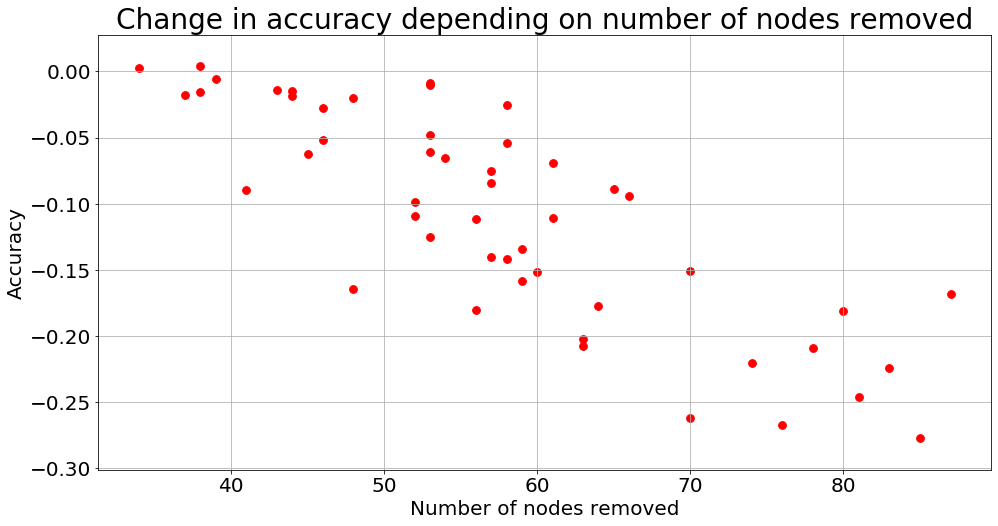

In [48]:
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_MLP_pre_calc_fmnist.png")

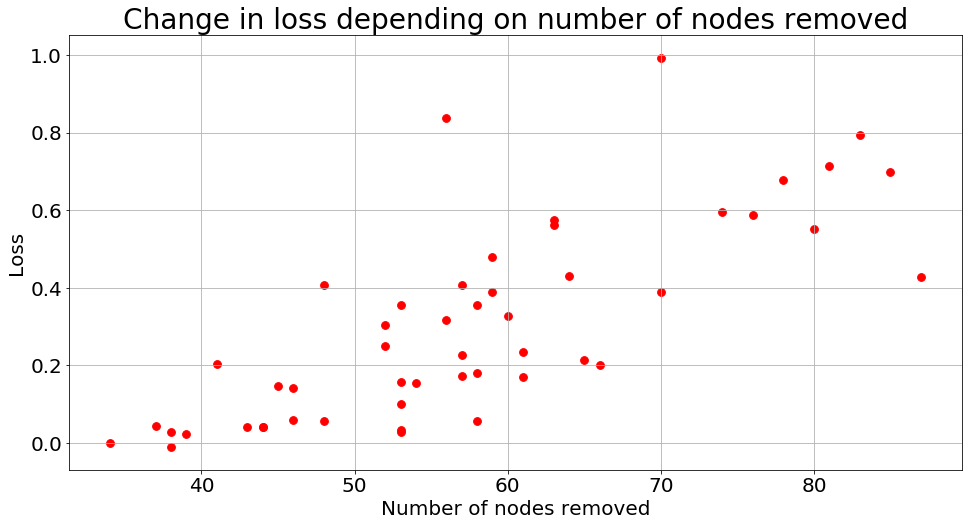

In [49]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_MLP_pre_calc_fmnist.png")

## Convolutional Neural Network

### MNIST

#### Set seed

In [50]:
np.random.seed(2020)

In [51]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

In [52]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
trials = 10
low_tol = -1e-5
high_tol = 1e-5
conv_layer_sizes = [256, 128, 64, 32]
dense_layer_sizes = [64]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    
    tmp_a, tmp_p = estimate_node_importance_conv(model, tester_model, dense_layer_sizes, conv_layer_sizes, low_tol, high_tol, x_train, y_train)
    
    tmp_rem = []
    
    for (nz, nw, _) in tmp_a:
        tmp_rem += [nz + nw]
    
    num_rem += [tmp_rem]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[0, 4, 10, 12, 13, 15, 18, 19, 22, 23, 27, 28, 31, 36, 37, 42, 45, 46, 47, 48, 51, 52, 58, 61, 62]
[3, 6, 33, 39, 55, 63]
[1, 7, 10, 25, 27, 28, 36, 38, 43, 46, 47, 49, 56, 58, 63, 65, 68, 74, 75, 76, 77, 78, 81, 86, 88, 95, 101, 115, 116, 117, 120, 124, 127, 128, 130, 140, 143, 157, 175, 177, 179, 181, 182, 183, 185, 203, 206, 211, 213, 214, 215, 220, 221, 223, 226, 231, 233, 235, 239, 242, 245, 252, 254]
[0, 2, 3, 6, 8, 9, 12, 13, 15, 18, 20, 35, 40, 42, 53, 54, 64, 80, 84, 89, 91, 92, 96, 106, 110, 113, 121, 149, 152, 156, 160, 165, 171, 174, 187, 190, 193, 194, 196, 198, 202, 207, 208, 227, 240, 244, 253]
[8, 39, 52, 68, 90, 105, 115]
[1, 9, 13, 15, 16, 17, 20, 30, 31, 32, 41, 44, 53, 64, 65, 69, 78, 81, 84, 85, 86, 91, 93, 95, 102, 103, 111, 113, 121, 125]
[]
[8, 11, 14, 16, 19, 20, 21, 22, 23, 28, 43, 44, 45, 46, 48, 49, 51]
[2, 11, 17, 19]
[0, 1, 10, 13, 20, 24, 26]


 10%|████████▏                                                                         | 1/10 [05:45<51:53, 345.94s/it]

[3, 7, 11, 13, 17, 18, 19, 23, 24, 25, 26, 27, 29, 31, 34, 40, 45, 49, 50, 51, 53, 56, 57, 60, 62, 63]
[37, 59]
[1, 2, 5, 8, 9, 12, 17, 18, 20, 23, 24, 26, 27, 30, 31, 33, 34, 38, 41, 45, 53, 54, 58, 64, 65, 68, 69, 72, 73, 81, 82, 83, 84, 85, 90, 91, 92, 94, 98, 102, 105, 107, 108, 109, 110, 112, 119, 120, 123, 124, 126, 127, 131, 132, 134, 136, 141, 142, 143, 144, 145, 146, 148, 150, 154, 155, 157, 163, 169, 173, 174, 179, 181, 182, 184, 193, 194, 195, 199, 200, 204, 205, 209, 210, 217, 218, 219, 220, 221, 223, 229, 231, 232, 234, 235, 237, 238, 242, 243, 244, 245, 246, 247, 249, 250, 253, 254]
[4, 10, 14, 16, 29, 35, 37, 42, 48, 49, 50, 52, 56, 59, 60, 62, 66, 67, 75, 76, 106, 111, 113, 121, 122, 125, 138, 140, 147, 156, 159, 166, 186, 187, 197, 202, 211, 212, 214, 215, 230, 233, 240]
[17, 27, 37, 39, 42, 45, 62, 63, 64, 78, 81, 82, 90, 101, 102, 110, 114, 117, 124]
[2, 22, 23, 32, 35, 44, 52, 56, 60, 67, 71, 79, 85, 86, 87, 94, 95, 103, 112, 115]
[19, 45, 62]
[9, 11, 25, 28, 42, 52

 20%|████████████████▍                                                                 | 2/10 [11:30<46:03, 345.48s/it]

[2, 4, 7, 12, 14, 15, 16, 18, 21, 23, 24, 25, 31, 32, 33, 35, 37, 39, 40, 41, 45, 48, 49, 50, 51, 57, 61]
[1, 17, 38, 47, 62]
[7, 8, 9, 14, 15, 19, 22, 25, 31, 34, 35, 42, 43, 44, 49, 55, 59, 60, 65, 73, 75, 76, 79, 82, 88, 89, 93, 95, 96, 98, 100, 103, 104, 107, 109, 110, 111, 117, 118, 119, 123, 129, 132, 134, 137, 141, 145, 148, 149, 164, 165, 167, 170, 173, 174, 176, 180, 181, 184, 194, 196, 198, 202, 204, 213, 217, 219, 222, 227, 233, 236, 237, 242, 243, 244, 253, 254, 255]
[1, 2, 3, 17, 20, 21, 26, 28, 30, 32, 37, 39, 45, 47, 52, 66, 78, 83, 84, 90, 99, 108, 121, 124, 130, 131, 135, 136, 144, 150, 151, 155, 162, 166, 169, 179, 182, 190, 191, 203, 209, 212, 214, 215, 216, 218, 223, 229, 247]
[19, 20, 32, 34, 65, 69, 75, 77, 86, 95, 96, 114, 120, 124]
[2, 7, 8, 21, 35, 37, 44, 49, 63, 68, 79, 83, 88, 91, 92, 94, 98, 105, 109, 111, 113, 117, 118, 123, 126]
[30, 43]
[5, 9, 12, 13, 17, 24, 25, 37, 41]
[3, 4, 7, 14, 18, 20]
[5, 15, 16, 27]


 30%|████████████████████████▌                                                         | 3/10 [17:16<40:20, 345.74s/it]

[2, 4, 9, 13, 15, 16, 19, 21, 24, 30, 37, 38, 44, 45, 50, 52, 61, 63]
[6, 18, 20, 23, 25, 54, 57, 59]
[2, 8, 9, 12, 13, 14, 16, 21, 22, 29, 32, 35, 36, 37, 38, 41, 46, 47, 49, 55, 56, 61, 62, 64, 67, 68, 69, 73, 75, 79, 80, 83, 86, 87, 88, 96, 102, 103, 106, 108, 110, 113, 114, 122, 125, 126, 132, 134, 138, 139, 140, 142, 143, 144, 149, 150, 156, 157, 159, 160, 163, 164, 165, 166, 176, 177, 180, 183, 187, 190, 191, 202, 203, 209, 217, 224, 225, 229, 230, 235, 238, 244, 245, 249, 250, 251, 255]
[0, 3, 4, 6, 23, 24, 25, 28, 44, 48, 50, 52, 58, 60, 63, 66, 91, 95, 100, 104, 105, 119, 121, 128, 133, 137, 148, 151, 155, 158, 162, 167, 171, 172, 174, 178, 182, 185, 194, 201, 204, 228, 231, 242, 246]
[11, 12, 20, 25, 38, 60, 68, 69, 70, 71, 79, 103, 105, 114, 119, 123]
[8, 13, 15, 17, 22, 23, 27, 28, 30, 37, 45, 50, 51, 58, 59, 65, 76, 84, 90, 97, 110, 112, 115, 118, 124]
[32, 55, 56]
[0, 5, 11, 19, 23, 27, 28, 39, 42, 44, 45, 58]
[0, 6, 15, 22, 24, 26, 29, 31]
[23]


 40%|████████████████████████████████▊                                                 | 4/10 [23:02<34:34, 345.68s/it]

[0, 2, 4, 5, 15, 16, 21, 22, 27, 28, 30, 31, 34, 36, 38, 40, 43, 46, 48, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62]
[9, 10, 12, 20, 23, 32, 33, 37, 39, 44]
[0, 2, 7, 10, 12, 15, 18, 20, 22, 25, 31, 33, 37, 47, 48, 49, 51, 52, 54, 55, 60, 63, 64, 65, 71, 74, 76, 79, 81, 83, 84, 91, 106, 107, 108, 122, 124, 125, 128, 129, 131, 141, 145, 146, 147, 148, 160, 165, 173, 174, 186, 188, 189, 190, 191, 192, 197, 198, 204, 205, 218, 220, 222, 223, 229, 237, 239, 240, 242, 245, 247, 254, 255]
[3, 5, 6, 11, 16, 26, 39, 40, 41, 42, 44, 45, 56, 69, 72, 86, 87, 89, 96, 97, 103, 112, 116, 123, 132, 133, 134, 135, 161, 166, 172, 175, 182, 184, 185, 194, 199, 201, 202, 207, 208, 210, 213, 216, 219, 226, 228, 231, 236, 251, 252]
[4, 15, 35, 43, 44, 59, 67, 102, 104, 110, 120, 125]
[9, 12, 13, 21, 24, 27, 29, 32, 33, 36, 41, 42, 45, 48, 51, 52, 53, 55, 56, 60, 61, 64, 68, 69, 70, 79, 87, 90, 96, 97, 99, 100, 103, 107, 108, 115, 117, 124]
[51]
[1, 2, 11, 13, 21, 25, 26, 27, 29, 39, 41, 44, 47, 48, 53,

 50%|█████████████████████████████████████████                                         | 5/10 [28:49<28:50, 346.10s/it]

[0, 2, 5, 7, 8, 12, 16, 17, 19, 20, 21, 24, 27, 28, 31, 35, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 51, 57, 60, 61, 62]
[1, 3, 11, 18, 23, 26, 43, 59, 63]
[1, 3, 9, 10, 13, 16, 18, 23, 25, 28, 36, 39, 40, 51, 60, 65, 78, 80, 83, 85, 92, 98, 99, 105, 106, 116, 117, 119, 120, 124, 130, 131, 132, 133, 139, 142, 145, 155, 159, 161, 166, 169, 178, 179, 183, 191, 195, 196, 198, 200, 213, 218, 222, 226, 232, 235, 237, 240, 251]
[4, 15, 17, 20, 21, 26, 43, 49, 53, 54, 57, 63, 67, 72, 81, 82, 84, 86, 88, 90, 93, 94, 101, 103, 104, 111, 127, 129, 134, 135, 143, 147, 148, 150, 157, 158, 162, 163, 167, 174, 175, 176, 187, 188, 189, 203, 205, 212, 214, 216, 220, 221, 229, 233, 238, 239, 242, 243, 247, 248, 249, 250]
[84, 89, 95, 102, 110]
[0, 2, 4, 5, 6, 7, 8, 9, 15, 16, 18, 23, 25, 27, 28, 34, 41, 42, 46, 48, 53, 54, 58, 64, 67, 68, 69, 70, 85, 87, 90, 94, 97, 98, 99, 101, 106, 108, 112, 113, 116, 121, 126, 127]
[25, 54]
[2, 3, 4, 5, 6, 10, 12, 13, 16, 19, 21, 22, 23, 27, 28, 29, 31, 34, 35, 40, 4

 60%|█████████████████████████████████████████████████▏                                | 6/10 [34:35<23:04, 346.07s/it]

[0, 7, 9, 11, 15, 16, 17, 18, 23, 29, 30, 34, 38, 39, 42, 44, 49, 51, 52, 53, 56, 57, 58, 60, 63]
[19, 20, 22, 32, 41, 45, 48, 54]
[2, 7, 13, 19, 21, 22, 24, 27, 28, 31, 33, 37, 45, 53, 60, 67, 74, 77, 78, 85, 86, 88, 98, 99, 104, 106, 107, 111, 112, 113, 114, 116, 118, 124, 125, 128, 130, 133, 135, 136, 142, 144, 149, 151, 158, 165, 167, 172, 174, 177, 180, 189, 192, 194, 195, 197, 199, 200, 202, 212, 213, 214, 229, 230, 236, 237, 240, 241, 245, 246, 249, 251, 254]
[1, 9, 14, 15, 16, 17, 20, 25, 29, 30, 32, 35, 38, 39, 41, 43, 46, 56, 58, 63, 68, 71, 73, 76, 82, 83, 89, 92, 93, 105, 115, 120, 131, 132, 140, 145, 152, 153, 157, 161, 179, 187, 190, 220, 225, 235]
[5, 24, 65, 68, 70, 75, 78, 83, 89, 92, 111, 112, 113, 123, 127]
[0, 2, 9, 10, 16, 20, 27, 34, 40, 44, 46, 47, 50, 56, 60, 66, 72, 74, 76, 77, 85, 86, 87, 103, 105, 107, 116, 117, 120, 126]
[23]
[3, 7, 8, 9, 12, 14, 16, 19, 27, 32, 40, 43, 47, 50, 51, 52, 57]
[11, 16, 17, 20]
[0, 5, 7, 19, 21, 31]


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [40:28<17:24, 348.23s/it]

[1, 3, 4, 9, 14, 16, 18, 19, 21, 24, 27, 29, 30, 31, 32, 34, 37, 39, 40, 42, 45, 46, 47, 52, 53, 55, 56, 57, 58, 59, 60, 63]
[2, 13, 43]
[1, 4, 9, 13, 16, 25, 27, 30, 32, 33, 35, 36, 46, 50, 51, 52, 57, 62, 67, 69, 75, 79, 80, 84, 89, 100, 103, 108, 109, 125, 127, 128, 131, 136, 138, 142, 149, 155, 166, 168, 169, 172, 173, 182, 186, 209, 212, 214, 216, 222, 224, 225, 231, 232, 239, 241, 245, 249, 250, 254, 255]
[2, 8, 11, 14, 19, 21, 23, 26, 29, 39, 42, 59, 65, 68, 70, 72, 73, 81, 83, 87, 90, 95, 96, 97, 105, 106, 107, 110, 112, 114, 116, 121, 126, 129, 132, 139, 146, 148, 152, 153, 154, 158, 160, 167, 188, 189, 201, 211, 218, 226, 227, 228, 233, 238, 242, 246, 251]
[19, 33, 43, 49, 61, 69, 70, 75, 76, 90, 120, 121, 124, 125]
[1, 4, 6, 12, 13, 22, 24, 26, 29, 31, 34, 39, 41, 44, 45, 46, 48, 50, 52, 53, 55, 57, 63, 64, 65, 67, 72, 82, 83, 84, 85, 86, 87, 89, 100, 101, 104, 105, 107, 113, 115, 119]
[19]
[4, 23, 27, 28, 30, 33, 46, 52, 54, 55, 60]
[8, 23, 27, 29]
[4, 10, 15, 16, 28, 30]


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [46:21<11:39, 349.51s/it]

[1, 2, 3, 5, 6, 8, 10, 13, 16, 17, 19, 22, 23, 24, 25, 26, 28, 31, 32, 33, 35, 36, 37, 39, 43, 44, 45, 46, 47, 48, 49, 51, 55, 56, 62]
[4, 54, 61]
[0, 5, 6, 7, 12, 14, 15, 21, 23, 26, 27, 31, 32, 34, 36, 38, 41, 48, 49, 51, 53, 55, 58, 63, 66, 67, 68, 69, 70, 71, 75, 76, 78, 80, 81, 85, 93, 94, 96, 98, 99, 102, 103, 104, 106, 107, 109, 110, 117, 118, 119, 120, 122, 123, 124, 125, 127, 138, 139, 141, 143, 146, 147, 154, 155, 156, 159, 160, 161, 162, 166, 168, 171, 172, 178, 179, 187, 189, 192, 193, 195, 196, 199, 201, 204, 205, 206, 209, 212, 214, 218, 220, 223, 226, 229, 230, 231, 233, 234, 235, 236, 242, 244, 247, 248, 253, 254, 255]
[2, 8, 10, 13, 17, 18, 19, 20, 24, 37, 40, 44, 45, 56, 82, 87, 97, 105, 115, 116, 121, 132, 135, 137, 149, 150, 151, 153, 164, 165, 169, 173, 174, 183, 184, 197, 198, 200, 202, 207, 215, 216, 217, 222, 224, 227, 238, 239, 243]
[11, 29, 47, 51, 53, 61, 67, 69, 70, 73, 82, 86, 87, 99, 111, 118, 119, 124]
[1, 7, 8, 14, 15, 16, 18, 22, 24, 26, 37, 38, 39, 41,

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [52:08<05:48, 348.75s/it]

[0, 4, 5, 6, 10, 13, 14, 15, 16, 20, 21, 28, 31, 34, 35, 36, 37, 38, 39, 48, 53, 55, 56, 57, 58, 61]
[1, 8, 18, 23, 27, 30, 43, 46, 54]
[1, 10, 14, 30, 35, 43, 52, 53, 57, 66, 71, 74, 79, 91, 92, 98, 100, 103, 105, 111, 112, 113, 114, 116, 120, 125, 127, 135, 138, 139, 140, 147, 148, 156, 159, 161, 164, 169, 176, 181, 183, 188, 191, 198, 199, 200, 201, 203, 206, 209, 213, 214, 227, 228, 230, 245, 248, 249, 250]
[0, 5, 6, 7, 8, 9, 12, 13, 17, 21, 24, 25, 31, 32, 33, 42, 45, 47, 48, 50, 55, 59, 61, 63, 64, 73, 81, 83, 84, 85, 87, 89, 97, 107, 108, 123, 132, 133, 137, 142, 145, 151, 163, 165, 166, 170, 177, 180, 185, 186, 190, 193, 194, 202, 207, 208, 210, 211, 212, 217, 219, 220, 221, 224, 225, 229, 231, 232, 233, 236, 240, 244, 252, 253]
[9, 12, 37, 50, 56, 64, 76, 89, 96, 102, 109]
[0, 4, 7, 8, 11, 16, 17, 20, 29, 30, 31, 32, 33, 34, 36, 42, 44, 47, 48, 49, 52, 53, 55, 59, 60, 66, 68, 77, 80, 83, 95, 100, 104, 106, 107, 108, 112, 118, 120, 122, 127]
[1, 11, 12, 17, 44]
[2, 3, 5, 18, 19

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [57:54<00:00, 347.47s/it]


In [54]:
NR = pd.DataFrame(num_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_CNN_pre_calc_mnist.csv')
NR.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.000000,10.000000,10.0000
mean,33.900000,129.100000,45.800000,16.400000,9.1000
std,4.909175,14.624561,6.511528,6.686637,3.3483
min,26.000000,110.000000,37.000000,10.000000,4.0000
25%,31.250000,119.500000,39.500000,11.250000,7.5000
50%,34.000000,125.500000,47.000000,16.000000,9.5000
75%,37.250000,132.750000,50.000000,18.000000,10.0000
max,41.000000,157.000000,56.000000,32.000000,16.0000


In [55]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_CNN_pre_calc_mnist.csv')
A.describe()

count    10.000000
mean     -0.122660
std       0.114597
min      -0.382600
25%      -0.163850
50%      -0.118700
75%      -0.028150
max      -0.006300
dtype: float64

In [56]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_CNN_pre_calc_mnist.csv')
L.describe()

count    10.000000
mean      0.437037
std       0.373134
min       0.050882
25%       0.150512
50%       0.401605
75%       0.595470
max       1.300833
dtype: float64

In [57]:
num_rem = [sum(rem) for rem in num_rem]

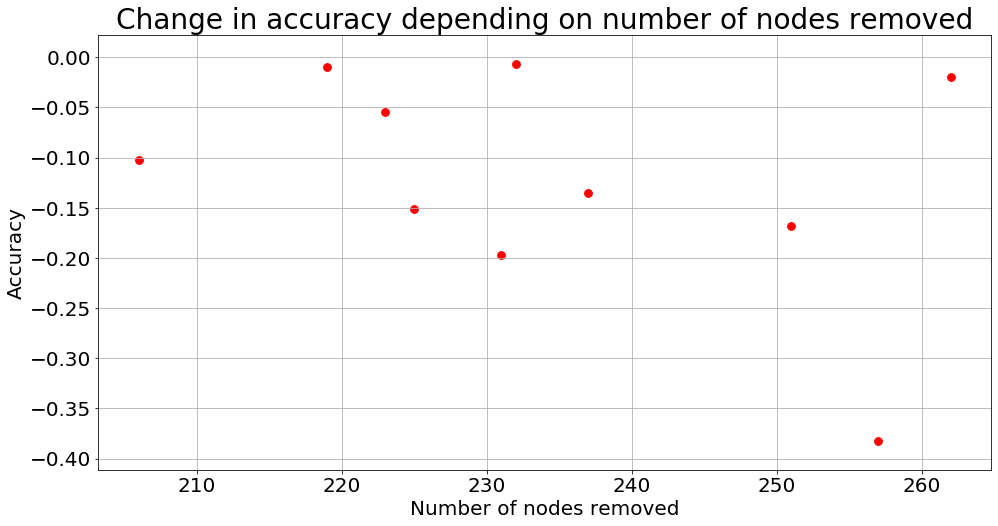

In [58]:
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_CNN_pre_calc_mnist.png")

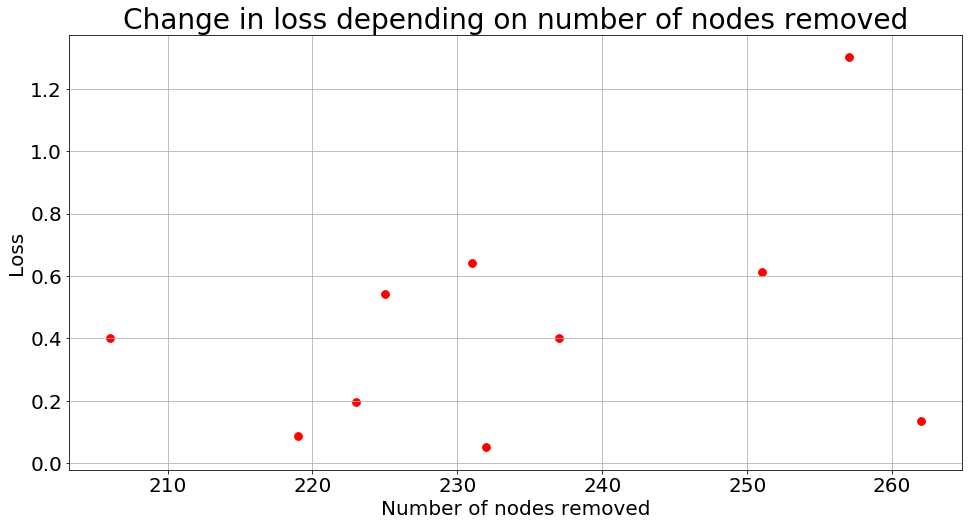

In [59]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_CNN_pre_calc_mnist.png")

### Fashion MNIST

#### Set seed

In [60]:
np.random.seed(2020)

In [61]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

In [62]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [63]:
trials = 10
low_tol = -1e-5
high_tol = 1e-5
conv_layer_sizes = [256, 128, 64, 32]
dense_layer_sizes = [64]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    
    tmp_a, tmp_p = estimate_node_importance_conv(model, tester_model, dense_layer_sizes, conv_layer_sizes, low_tol, high_tol, x_train, y_train)
    tmp_rem = []
    
    for (nz, nw, _) in tmp_a:
        tmp_rem += [nz + nw]
    
    num_rem += [tmp_rem]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 10, 11, 12, 13, 18, 19, 22, 26, 31, 32, 34, 35, 40, 43, 52, 54, 57, 58, 60]
[53, 55]
[5, 8, 14, 15, 24, 28, 29, 38, 43, 53, 65, 76, 85, 90, 92, 94, 95, 97, 114, 115, 120, 122, 124, 129, 131, 137, 143, 146, 150, 151, 152, 157, 158, 163, 170, 176, 179, 182, 185, 187, 192, 193, 194, 195, 213, 214, 217, 218, 219, 222, 223, 231, 236]
[10, 18, 22, 44, 49, 68, 117, 123, 127, 130, 134, 209, 210, 216, 221, 224, 229, 246, 248, 255]
[21, 27, 47, 50, 63, 75, 89, 94]
[8, 10, 12, 16, 23, 28, 30, 35, 48, 66, 72, 79, 83, 106, 122, 123, 124]
[]
[36, 46, 47]
[9, 30]
[6, 26]


 10%|████████▏                                                                         | 1/10 [05:46<52:02, 346.98s/it]

[1, 2, 5, 8, 9, 12, 18, 19, 25, 26, 27, 28, 33, 36, 45, 46, 47, 51, 56]
[11, 14, 30, 38, 44, 60]
[2, 4, 15, 17, 19, 22, 23, 25, 28, 31, 35, 57, 59, 71, 84, 107, 113, 114, 133, 139, 141, 149, 152, 171, 178, 194, 201, 204, 212, 213, 225, 228, 231, 233, 239, 246, 249, 250, 251, 252]
[8, 26, 27, 32, 38, 41, 48, 51, 53, 55, 58, 67, 68, 75, 81, 88, 93, 95, 98, 108, 118, 126, 127, 142, 150, 157, 158, 165, 167, 168, 174, 183, 184, 186, 187, 190, 197, 198, 224, 236, 242]
[25, 43, 58, 76, 121, 127]
[2, 11, 32, 36, 37, 39, 42, 45, 55, 56, 59, 72, 74, 81, 92, 95, 99, 100, 102, 103, 105, 114, 118, 120, 125]
[20, 54]
[0, 4, 17, 26, 28]
[]
[]


 20%|████████████████▍                                                                 | 2/10 [11:32<46:12, 346.60s/it]

[2, 3, 8, 11, 16, 17, 20, 28, 31, 33, 37, 38, 40, 41, 42, 46, 47, 49, 50, 53, 57]
[21, 23, 56, 60]
[5, 24, 28, 31, 34, 38, 41, 42, 43, 46, 52, 61, 71, 76, 88, 103, 106, 109, 111, 121, 133, 137, 143, 146, 147, 152, 156, 171, 172, 180, 188, 190, 195, 202, 207, 209, 220, 229, 230, 231, 234, 235, 242, 243, 251, 255]
[1, 23, 48, 50, 54, 68, 85, 90, 97, 99, 104, 115, 118, 124, 142, 144, 149, 181, 193, 211, 213, 223, 225, 241, 244, 245, 247, 250, 254]
[0, 5, 30, 52, 53, 57, 67, 74, 77, 89, 91, 94, 95]
[4, 6, 15, 19, 34, 39, 42, 45, 62, 66, 73, 86, 100, 119, 122, 123, 125, 126]
[7, 9, 20]
[0, 8, 25, 36, 37, 40, 41, 42, 50, 52, 59, 61, 63]
[]
[2, 7, 14, 18, 20]


 30%|████████████████████████▌                                                         | 3/10 [17:16<40:21, 345.90s/it]

[0, 1, 4, 5, 6, 7, 9, 10, 11, 14, 16, 17, 19, 20, 21, 24, 25, 29, 30, 31, 33, 36, 40, 42, 45, 54, 59, 60, 62, 63]
[22, 32]
[9, 17, 22, 31, 35, 36, 55, 61, 63, 66, 69, 78, 85, 89, 96, 105, 110, 115, 116, 129, 131, 134, 143, 157, 158, 160, 162, 163, 164, 176, 178, 183, 191, 192, 194, 196, 199, 206, 216, 229, 233, 236, 253]
[6, 23, 27, 32, 33, 56, 59, 64, 70, 72, 77, 81, 84, 88, 103, 104, 127, 136, 149, 166, 169, 173, 180, 184, 197, 214, 220, 231, 240, 242, 243, 247, 248, 249, 254, 255]
[21, 26, 27, 31, 43, 53, 54, 58, 66, 78]
[8, 24, 28, 29, 34, 36, 46, 48, 49, 50, 63, 72, 81, 84, 90, 97, 98, 101, 103, 117, 121]
[]
[0, 2, 14, 33, 36, 43, 53]
[11, 14, 30]
[21]


 40%|████████████████████████████████▊                                                 | 4/10 [23:02<34:35, 345.89s/it]

[2, 4, 5, 6, 7, 8, 11, 16, 17, 22, 25, 26, 28, 31, 32, 33, 35, 38, 40, 46, 51, 54, 55, 56, 57]
[0, 3, 15, 20, 29, 36, 37, 43, 44, 59]
[0, 7, 8, 18, 31, 35, 38, 53, 57, 58, 61, 67, 74, 80, 94, 100, 106, 107, 114, 118, 124, 129, 131, 132, 138, 139, 141, 145, 146, 148, 150, 151, 156, 162, 169, 170, 179, 181, 185, 194, 197, 198, 212, 213, 214, 218, 219, 220, 226, 228, 239, 243, 247, 251, 255]
[1, 3, 4, 10, 11, 12, 26, 27, 29, 30, 34, 44, 50, 54, 55, 68, 72, 73, 75, 78, 79, 88, 90, 98, 105, 112, 116, 120, 121, 122, 127, 128, 133, 135, 153, 154, 155, 157, 158, 161, 166, 171, 180, 188, 191, 192, 211, 216, 217, 221, 223, 224, 225, 227, 229, 240, 241, 242, 245]
[1, 21, 23, 29, 31, 32, 38, 42, 48, 70, 73, 88, 91, 92]
[10, 15, 22, 41, 47, 52, 55, 56, 61, 67, 79, 81, 84, 87, 97, 98, 99, 100, 107, 110, 114, 116, 117, 118, 126]
[]
[0, 2, 4, 5, 6, 8, 19, 26, 28, 29, 31, 33, 35, 37, 47, 48, 50, 56, 58, 61]
[]
[6, 7, 8, 13, 15, 17, 19, 29]


 50%|█████████████████████████████████████████                                         | 5/10 [28:49<28:50, 346.01s/it]

[1, 3, 4, 7, 8, 10, 15, 16, 19, 20, 35, 36, 37, 42, 43, 48, 50, 52, 63]
[28, 59]
[0, 1, 2, 9, 11, 12, 13, 14, 17, 25, 26, 31, 39, 66, 70, 76, 77, 78, 84, 87, 100, 104, 110, 111, 112, 113, 118, 119, 123, 137, 143, 147, 167, 173, 174, 177, 183, 189, 197, 198, 201, 209, 211, 214, 216, 218, 220, 221, 222, 231, 245, 248, 250, 252]
[3, 19, 21, 28, 36, 38, 40, 48, 52, 53, 57, 59, 62, 80, 81, 83, 98, 99, 109, 121, 125, 141, 146, 152, 161, 164, 166, 172, 202, 205, 213, 227, 237, 239, 240, 242, 246]
[20, 27, 29, 41, 44, 48, 69, 72, 79, 85, 92, 106, 113, 122, 126]
[3, 12, 26, 32, 49, 52, 60, 73, 77, 83, 88, 100, 104, 112]
[46]
[2, 21, 42, 45, 53]
[]
[27]


 60%|█████████████████████████████████████████████████▏                                | 6/10 [34:35<23:04, 346.23s/it]

[1, 3, 4, 5, 6, 7, 9, 12, 13, 25, 26, 30, 33, 35, 39, 40, 42, 43, 44, 45, 49, 51, 52, 55, 60, 61]
[18, 20, 28, 29, 36, 46, 62]
[1, 8, 29, 30, 33, 41, 43, 54, 56, 92, 105, 112, 116, 120, 121, 122, 123, 129, 141, 154, 159, 170, 175, 176, 191, 204, 209, 210, 212, 223, 225, 236, 238, 241, 249, 254]
[4, 11, 32, 48, 62, 64, 66, 69, 70, 75, 81, 83, 85, 89, 97, 101, 111, 113, 127, 131, 134, 144, 150, 151, 153, 156, 157, 158, 177, 188, 190, 193, 197, 220, 222, 235, 237, 252, 255]
[0, 14, 22, 34, 36, 38, 57, 62, 66, 79, 123, 126]
[8, 10, 12, 13, 16, 19, 27, 29, 43, 50, 51, 53, 54, 63, 65, 70, 78, 81, 86, 87, 90, 92, 105, 116, 118, 119, 122]
[]
[23, 36, 47, 49, 50, 60]
[]
[0, 20, 22, 24, 26]


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [40:20<17:17, 345.78s/it]

[2, 4, 7, 8, 9, 12, 13, 14, 15, 17, 18, 22, 26, 35, 46, 55, 57, 60, 61]
[1, 3, 5, 23, 47, 49]
[11, 12, 13, 14, 20, 50, 53, 55, 56, 62, 65, 66, 69, 77, 78, 81, 87, 104, 105, 113, 117, 119, 145, 159, 160, 166, 172, 178, 184, 185, 194, 207, 209, 225, 232, 236, 247, 248, 249, 252, 253, 255]
[10, 34, 38, 61, 74, 75, 90, 94, 101, 106, 126, 138, 146, 148, 158, 199, 213, 223, 227, 234, 242]
[19, 21, 29, 58, 67, 76, 87, 93, 114, 125]
[1, 16, 18, 23, 33, 35, 45, 54, 64, 71, 82, 88, 89, 102, 119]
[21]
[12, 49, 50, 61]
[]
[5, 19, 29]


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [46:04<11:30, 345.27s/it]

[1, 5, 7, 8, 12, 16, 17, 20, 22, 26, 29, 30, 31, 33, 40, 46, 47, 48, 52, 57, 58, 60, 63]
[4, 28, 39, 49]
[9, 10, 16, 17, 27, 37, 41, 46, 57, 60, 61, 66, 67, 69, 73, 76, 83, 87, 92, 107, 121, 125, 135, 149, 153, 156, 163, 165, 172, 179, 181, 188, 195, 202, 205, 212, 216, 234, 235, 236, 238, 245]
[13, 19, 28, 38, 62, 94, 100, 108, 112, 119, 150, 160, 164, 167, 197, 201, 228, 250, 251]
[8, 21, 73, 77, 88, 97, 100, 115]
[10, 14, 16, 18, 22, 28, 40, 44, 57, 67, 74, 79, 81, 103, 105, 108, 113, 114, 117]
[]
[10, 11, 19, 30]
[18]
[10, 27]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [51:50<05:45, 345.43s/it]

[2, 3, 5, 6, 8, 14, 15, 16, 17, 18, 24, 25, 31, 37, 38, 43, 48, 50, 55, 58, 61, 62, 63]
[1, 10, 11, 12, 23, 30, 45]
[0, 3, 9, 13, 28, 39, 41, 44, 45, 51, 57, 58, 60, 62, 70, 76, 93, 109, 111, 116, 117, 133, 134, 167, 174, 179, 185, 188, 198, 202, 208, 209, 215, 216, 218, 233, 242]
[15, 16, 30, 35, 42, 54, 65, 69, 84, 89, 112, 123, 128, 132, 142, 147, 155, 160, 163, 168, 171, 175, 177, 180, 193, 197, 201, 203, 206, 212, 213, 252, 253, 254, 255]
[0, 1, 12, 24, 26, 30, 87, 93, 113, 117]
[10, 21, 22, 25, 32, 38, 43, 45, 54, 59, 65, 73, 78, 85, 96, 112, 120, 122, 123]
[]
[33, 57]
[]
[]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [57:36<00:00, 345.66s/it]


In [64]:
NR = pd.DataFrame(num_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_CNN_pre_calc_fmnist.csv')
NR.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,28.000000,78.400000,30.600000,7.600000,3.300000
std,4.371626,15.152558,4.971027,5.796551,2.496664
min,21.000000,61.000000,25.000000,2.000000,0.000000
25%,25.000000,72.250000,27.500000,4.250000,1.500000
50%,27.000000,75.000000,30.000000,6.000000,3.500000
75%,31.500000,80.500000,31.000000,7.000000,4.750000
max,35.000000,114.000000,39.000000,20.000000,8.000000


In [65]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_CNN_pre_calc_fmnist.csv')
A.describe()

count    10.000000
mean     -0.030200
std       0.036376
min      -0.098600
25%      -0.040450
50%      -0.014750
75%      -0.005850
max       0.000000
dtype: float64

In [66]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_CNN_pre_calc_fmnist.csv')
L.describe()

count    10.000000
mean      0.082566
std       0.094129
min       0.002708
25%       0.016755
50%       0.047042
75%       0.104033
max       0.256795
dtype: float64

In [67]:
num_rem = [sum(rem) for rem in num_rem]

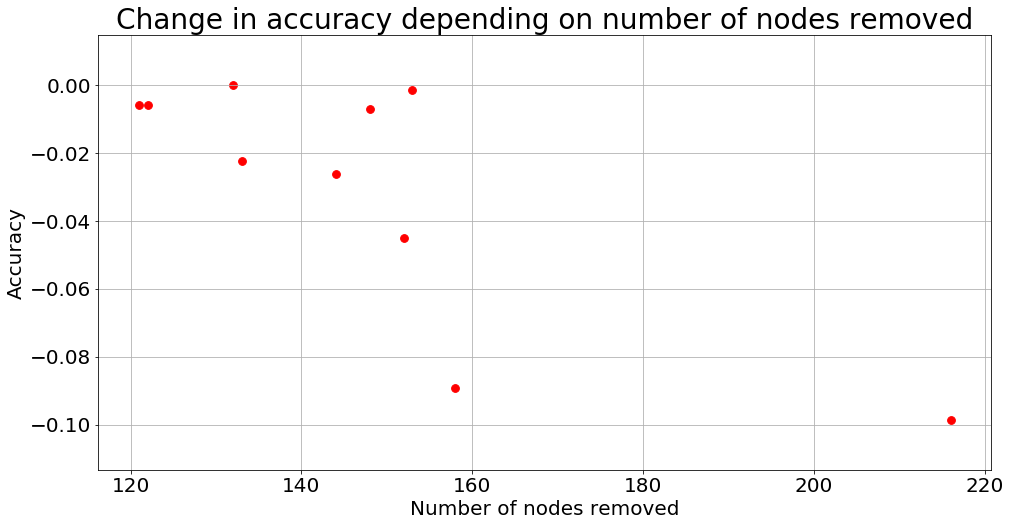

In [68]:
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_CNN_pre_calc_fmnist.png")

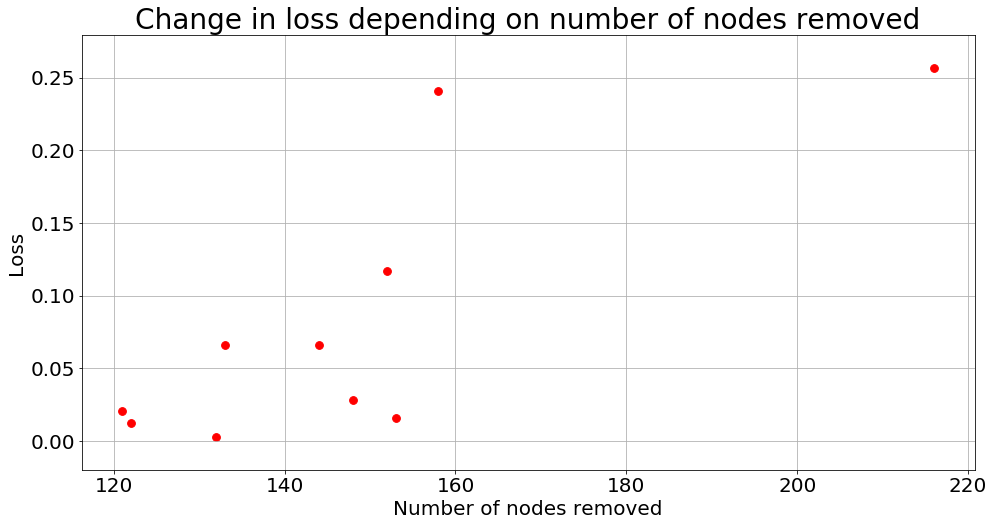

In [69]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_CNN_pre_calc_fmnist.png")

### CIFAR10

#### Set seed

In [70]:
np.random.seed(2020)

In [71]:
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [72]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [73]:
trials = 10
low_tol = -1e-5
high_tol = 1e-5
conv_layer_sizes = [256, 128, 64, 32]
dense_layer_sizes = [64]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    
    tmp_a, tmp_p = estimate_node_importance_conv(model, tester_model, dense_layer_sizes, conv_layer_sizes, low_tol, high_tol, x_train, y_train)
    tmp_rem = []
    
    for (nz, nw, _) in tmp_a:
        tmp_rem += [nz + nw]
    
    num_rem += [tmp_rem]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 41, 42, 47, 48, 49, 52, 56, 57, 61, 63]
[]
[0, 2, 9, 11, 13, 15, 23, 27, 30, 34, 35, 37, 40, 43, 45, 46, 50, 53, 55, 56, 58, 59, 60, 69, 71, 73, 77, 79, 83, 84, 86, 87, 89, 90, 95, 100, 106, 108, 110, 112, 113, 116, 122, 124, 129, 131, 137, 141, 142, 153, 158, 161, 163, 166, 169, 172, 174, 175, 176, 178, 181, 186, 188, 194, 195, 197, 201, 204, 207, 208, 209, 212, 213, 214, 218, 219, 221, 227, 230, 231, 233, 234, 235, 237, 238, 240, 243, 247, 249, 250, 251, 252]
[6, 8, 25, 64, 82, 88, 91, 93, 96, 99, 111, 117, 121, 130, 132, 138, 146, 152, 154, 177, 187, 192, 199, 211, 228, 229, 241, 245, 246]
[2, 4, 5, 6, 10, 14, 18, 19, 21, 23, 25, 27, 42, 44, 47, 51, 52, 59, 62, 68, 71, 72, 73, 74, 75, 78, 86, 89, 105, 109, 110, 111, 113, 118, 122, 126, 127]
[3, 9, 24, 28, 32, 36, 53, 56, 65, 67, 88, 92, 99, 103, 112, 117]
[0, 5, 11, 13, 15, 18, 19, 22, 30, 33, 35, 40, 57, 59]
[8, 

 10%|████████                                                                        | 1/10 [09:10<1:22:30, 550.05s/it]

[1, 4, 5, 6, 7, 8, 10, 11, 16, 17, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 41, 42, 43, 44, 46, 47, 49, 50, 54, 56, 57, 62, 63]
[]
[3, 6, 13, 16, 19, 31, 32, 40, 45, 51, 52, 54, 56, 62, 63, 65, 68, 71, 72, 74, 75, 81, 82, 84, 85, 86, 87, 98, 100, 104, 107, 108, 109, 111, 114, 119, 121, 124, 125, 127, 129, 133, 136, 142, 144, 146, 151, 152, 155, 159, 165, 168, 170, 171, 172, 173, 176, 179, 180, 188, 189, 190, 194, 197, 210, 217, 218, 219, 223, 224, 227, 229, 230, 231, 233, 234, 252, 253, 254]
[26, 34, 35, 39, 99, 115, 123, 137, 143, 145, 163, 175, 185, 186, 196, 228, 236, 248, 251]
[3, 6, 7, 15, 17, 18, 26, 31, 33, 38, 39, 40, 41, 43, 44, 46, 58, 70, 75, 82, 86, 90, 91, 111, 113, 114, 117, 124]
[2, 16, 45]
[10, 12, 17, 32, 39, 43, 48, 51]
[7]
[6]
[10, 23, 31]


 20%|████████████████                                                                | 2/10 [18:26<1:13:34, 551.82s/it]

[0, 1, 2, 5, 9, 12, 13, 14, 19, 21, 22, 24, 25, 26, 29, 33, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 52, 60, 61, 62, 63]
[4, 16, 51]
[5, 10, 15, 17, 24, 40, 42, 47, 50, 51, 55, 64, 66, 78, 87, 93, 97, 99, 103, 105, 109, 111, 113, 114, 118, 119, 120, 123, 124, 127, 129, 132, 134, 144, 149, 153, 154, 156, 159, 161, 164, 167, 168, 172, 174, 179, 181, 182, 185, 188, 192, 196, 198, 202, 204, 205, 207, 209, 213, 216, 220, 221, 231, 232, 233, 234, 240, 243, 247, 252, 253, 254]
[9, 13, 27, 34, 54, 69, 75, 76, 89, 90, 106, 107, 116, 125, 130, 131, 139, 141, 151, 166, 169, 183, 194, 195, 210, 211, 212, 228, 241, 248, 255]
[5, 6, 7, 9, 10, 11, 13, 22, 25, 30, 35, 41, 43, 44, 56, 64, 67, 70, 71, 76, 78, 79, 91, 93, 94, 99, 107, 108, 122]
[40, 57, 84, 85, 92, 98, 103, 112]
[9, 13, 15, 19, 22, 24, 34, 59]
[8, 23]
[10, 14, 22, 24, 26]
[9]


 30%|████████████████████████                                                        | 3/10 [27:36<1:04:20, 551.45s/it]

[0, 1, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 20, 21, 23, 25, 26, 27, 32, 33, 36, 38, 39, 40, 41, 42, 44, 49, 50, 51, 54, 56, 58, 61, 63]
[10, 45]
[1, 5, 11, 13, 16, 17, 19, 20, 23, 25, 28, 33, 35, 38, 41, 42, 43, 46, 54, 56, 59, 70, 74, 79, 82, 90, 92, 106, 107, 109, 115, 119, 123, 128, 129, 132, 136, 138, 142, 145, 149, 153, 157, 159, 162, 163, 164, 167, 170, 173, 174, 175, 186, 187, 196, 198, 200, 201, 203, 206, 212, 213, 214, 216, 217, 220, 222, 235, 243, 248, 249, 253]
[2, 7, 14, 44, 48, 73, 78, 80, 81, 103, 104, 121, 126, 127, 134, 139, 141, 146, 152, 195, 197, 208, 209, 228, 229, 233, 237, 245, 246]
[4, 5, 11, 12, 14, 15, 20, 22, 30, 34, 35, 39, 40, 41, 46, 49, 51, 54, 57, 67, 71, 73, 78, 85, 89, 92, 96, 98, 99, 100, 123, 125]
[18, 27, 50, 53, 66, 72, 80, 86, 103, 106, 111, 116, 117]
[6, 42, 47, 62]
[0, 56, 58]
[5]
[12]


 40%|████████████████████████████████▊                                                 | 4/10 [36:47<55:07, 551.23s/it]

[0, 3, 4, 6, 7, 8, 9, 12, 15, 16, 20, 21, 22, 24, 25, 26, 28, 29, 34, 35, 36, 38, 42, 46, 47, 48, 52, 56, 60, 62, 63]
[]
[10, 13, 22, 24, 33, 38, 39, 45, 53, 59, 65, 69, 70, 71, 78, 79, 80, 83, 85, 89, 93, 94, 101, 107, 111, 119, 120, 121, 122, 132, 134, 137, 138, 141, 149, 152, 155, 159, 165, 171, 173, 176, 179, 180, 182, 187, 192, 203, 208, 210, 211, 213, 230, 236, 238, 243, 246, 254]
[2, 21, 41, 44, 55, 76, 103, 108, 109, 126, 127, 150, 166, 191, 194, 207, 222, 223, 237]
[6, 7, 8, 11, 13, 16, 20, 22, 31, 35, 46, 63, 66, 67, 70, 90, 107, 113, 123]
[2, 17, 19, 74, 75, 77, 78, 86, 88, 106, 121]
[26, 27, 32, 36, 44, 62]
[13, 19, 35, 53]
[6, 20, 27]
[30]


 50%|█████████████████████████████████████████                                         | 5/10 [45:58<45:56, 551.28s/it]

[2, 3, 4, 6, 9, 10, 12, 14, 15, 17, 19, 20, 23, 24, 27, 28, 32, 33, 34, 38, 40, 43, 44, 45, 47, 48, 49, 50, 52, 53, 55, 57, 58, 59, 60, 61, 62]
[]
[4, 6, 8, 18, 21, 22, 24, 25, 27, 36, 43, 45, 52, 55, 56, 58, 65, 69, 74, 75, 80, 82, 83, 84, 85, 86, 88, 89, 91, 93, 95, 96, 97, 102, 109, 121, 122, 125, 126, 135, 141, 144, 148, 149, 151, 152, 154, 155, 157, 161, 165, 166, 167, 171, 172, 174, 175, 176, 181, 186, 189, 192, 197, 202, 205, 207, 209, 224, 225, 227, 228, 237, 239, 241, 246, 254]
[15, 60, 68, 92, 142, 215, 220]
[5, 15, 19, 24, 32, 35, 38, 50, 53, 56, 59, 62, 71, 73, 76, 79, 83, 91, 92, 94, 108, 115, 117]
[40, 47, 75, 90, 121, 126]
[1, 5, 12, 27, 28, 43, 44, 46, 53, 61]
[47]
[17, 22]
[]


 60%|█████████████████████████████████████████████████▏                                | 6/10 [55:17<36:53, 553.49s/it]

[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 17, 18, 19, 20, 21, 22, 24, 26, 28, 29, 30, 32, 34, 35, 36, 37, 41, 43, 44, 46, 47, 48, 49, 51, 52, 60, 61, 62, 63]
[55]
[0, 2, 5, 6, 14, 15, 21, 23, 35, 36, 39, 41, 44, 49, 50, 51, 52, 54, 64, 71, 72, 75, 83, 89, 90, 91, 92, 94, 98, 102, 114, 120, 122, 125, 130, 133, 140, 145, 149, 150, 153, 156, 157, 158, 163, 167, 168, 170, 171, 175, 178, 180, 181, 183, 186, 189, 193, 195, 196, 199, 200, 203, 205, 207, 208, 209, 212, 214, 217, 219, 223, 227, 230, 237, 244, 245]
[13, 17, 26, 30, 38, 46, 53, 59, 77, 82, 104, 109, 112, 119, 121, 132, 161, 164, 169, 177, 184, 190, 218, 222, 235, 247, 253]
[5, 6, 8, 18, 25, 26, 29, 45, 55, 56, 59, 74, 75, 76, 93, 97, 101, 102, 103, 104, 107, 113, 114, 116, 121]
[3, 16, 23, 36, 54, 64, 72, 99, 108, 117, 118, 119, 123]
[1, 5, 10, 24, 26, 35, 36, 37, 40, 45, 46, 47, 49, 60, 61]
[]
[]
[15, 26, 28, 30]


 70%|████████████████████████████████████████████████████████                        | 7/10 [1:04:44<27:52, 557.56s/it]

[0, 1, 2, 4, 5, 6, 7, 8, 9, 12, 16, 17, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 32, 33, 34, 35, 37, 38, 41, 43, 44, 45, 46, 47, 49, 50, 52, 53, 55, 58, 60, 61, 62, 63]
[]
[0, 6, 10, 12, 14, 18, 19, 20, 22, 25, 28, 31, 32, 33, 34, 37, 38, 41, 44, 45, 46, 47, 56, 57, 58, 63, 64, 68, 71, 73, 76, 77, 78, 80, 82, 84, 89, 91, 92, 94, 101, 102, 103, 106, 107, 111, 112, 113, 114, 122, 124, 128, 133, 136, 137, 138, 144, 145, 146, 149, 152, 153, 155, 156, 160, 161, 165, 166, 167, 168, 169, 170, 171, 173, 179, 181, 183, 186, 187, 193, 196, 198, 199, 201, 204, 205, 209, 215, 216, 217, 221, 227, 229, 230, 231, 234, 237, 241, 242, 245, 247, 248, 251]
[17, 30, 48, 86, 90, 98, 117, 119, 126, 130, 132, 134, 135, 141, 143, 148, 176, 178, 190, 192, 202, 207, 220, 250]
[2, 9, 16, 17, 20, 22, 31, 52, 58, 62, 71, 76, 77, 83, 87, 106, 107, 110, 119, 122]
[0, 11, 18, 28, 60, 63, 80, 85, 88, 93, 101, 102, 108, 118]
[1, 11, 18, 23, 26, 30, 34, 38, 45, 49, 53, 63]
[47]
[9, 21]
[20, 24]


 80%|████████████████████████████████████████████████████████████████                | 8/10 [1:13:53<18:30, 555.16s/it]

[0, 3, 5, 7, 8, 15, 16, 18, 19, 21, 22, 23, 25, 26, 27, 29, 30, 31, 32, 33, 35, 37, 38, 39, 40, 41, 44, 45, 46, 51, 52, 53, 55, 57, 61]
[42]
[0, 5, 21, 23, 25, 27, 30, 36, 40, 48, 53, 60, 65, 66, 71, 73, 79, 80, 82, 85, 88, 97, 100, 107, 109, 117, 123, 124, 125, 129, 130, 132, 133, 136, 137, 138, 139, 143, 147, 149, 151, 165, 166, 171, 176, 178, 182, 184, 186, 190, 194, 197, 200, 205, 207, 209, 211, 218, 224, 226, 227, 228, 229, 231, 236, 238, 243, 250, 254]
[10, 47, 64, 69, 101, 142, 157, 159, 160, 175, 198, 203, 242, 244, 249]
[10, 22, 25, 33, 36, 59, 65, 72, 77, 81, 87, 95, 98, 114, 116, 117, 119]
[11, 18, 19, 30, 41, 54, 67, 88, 93, 120, 122, 126]
[0, 8, 15, 18, 21, 57]
[16, 42, 48, 51, 54]
[3, 8, 31]
[1]


 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [1:23:07<09:14, 554.65s/it]

[0, 1, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 17, 20, 23, 24, 26, 30, 31, 32, 37, 38, 42, 43, 47, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 63]
[27]
[2, 6, 11, 13, 18, 22, 23, 31, 32, 33, 39, 51, 52, 53, 54, 61, 66, 69, 70, 75, 84, 86, 91, 95, 106, 111, 122, 133, 145, 155, 159, 160, 161, 165, 166, 170, 171, 173, 174, 175, 179, 185, 186, 194, 202, 204, 205, 206, 209, 211, 213, 215, 216, 217, 218, 219, 221, 224, 229, 230, 231, 232, 233, 234, 241, 243, 244, 255]
[12, 25, 50, 55, 63, 67, 82, 98, 102, 107, 112, 114, 117, 121, 131, 136, 142, 172, 191, 192, 199, 207, 208, 212, 220, 225, 227, 239, 248]
[2, 3, 5, 6, 8, 14, 22, 25, 27, 30, 33, 36, 38, 40, 52, 54, 59, 66, 71, 75, 78, 81, 87, 92, 93, 94, 103, 112, 119, 122]
[45, 53, 60, 61, 62, 102, 114]
[1, 11, 12, 13, 35, 46, 54]
[2, 8, 25, 59]
[0, 18]
[24]


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:32:26<00:00, 554.68s/it]


In [74]:
NR = pd.DataFrame(num_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_CNN_pre_calc_cifar.csv')
NR.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.000000,10.000000,10.00000
mean,38.900000,99.400000,36.300000,11.600000,3.90000
std,3.754997,15.889899,7.732328,3.373096,1.37032
min,31.000000,77.000000,29.000000,7.000000,2.00000
25%,37.250000,87.250000,30.250000,10.000000,3.25000
50%,39.000000,99.500000,35.500000,11.000000,4.00000
75%,41.750000,103.000000,37.750000,12.500000,4.00000
max,44.000000,127.000000,53.000000,19.000000,6.00000


In [75]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_CNN_pre_calc_cifar.csv')
A.describe()

count    10.000000
mean     -0.057930
std       0.067965
min      -0.237600
25%      -0.063350
50%      -0.042250
75%      -0.032125
max       0.004100
dtype: float64

In [76]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_CNN_pre_calc_cifar.csv')
L.describe()

count    10.000000
mean      0.176195
std       0.261105
min      -0.027520
25%       0.053408
50%       0.110574
75%       0.181242
max       0.885364
dtype: float64

In [77]:
num_rem = [sum(rem) for rem in num_rem]

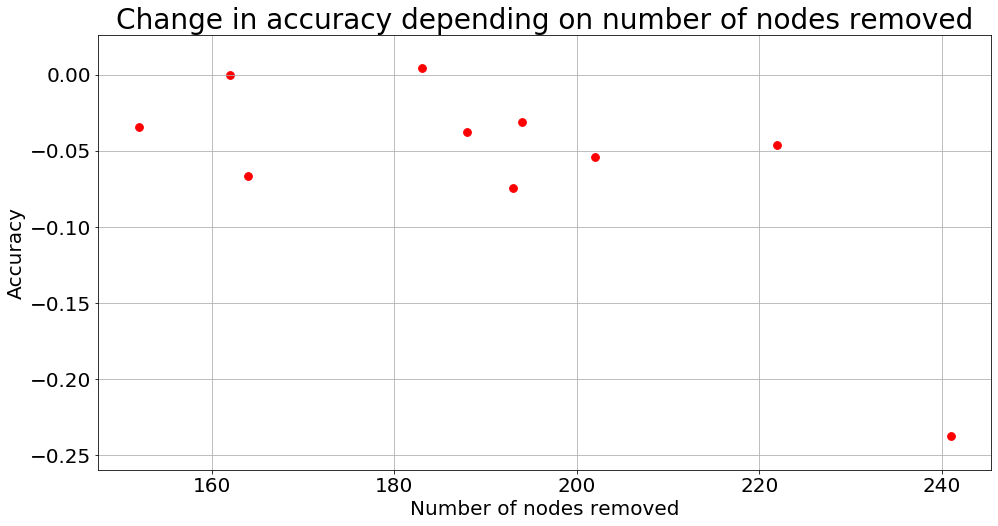

In [78]:
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_CNN_pre_calc_cifar.png")

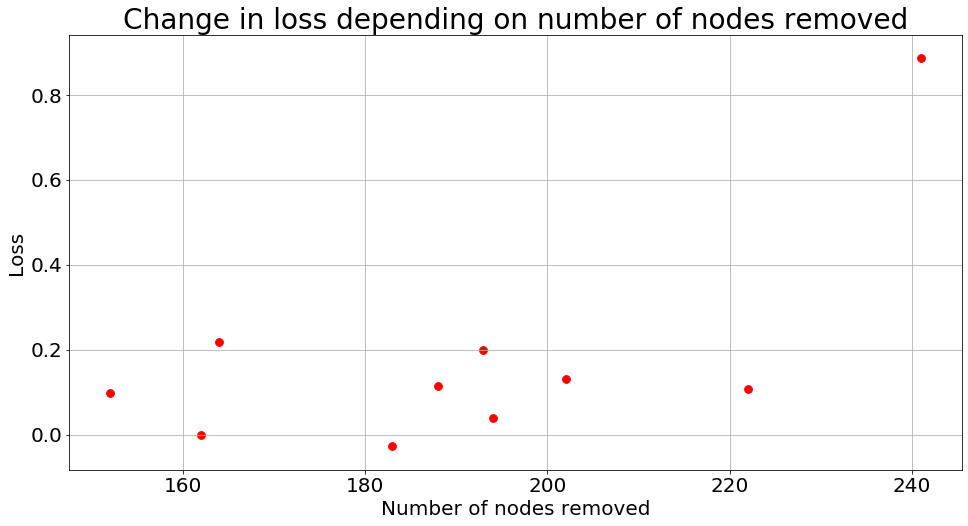

In [79]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_CNN_pre_calc_cifar.png")

# Pruning based on validation sets

## Single-layer ANN

### MNIST

#### Set seed

In [24]:
np.random.seed(2020)

In [25]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [26]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
trials = 50
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model, r = models.train_basic_ANN(x_train, y_train, 128, (x_val, y_val), epochs=5)
    tmp_a, tmp_p = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
    num_rem += [tmp_a[0][0] + tmp_a[0][1]]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:52<00:00, 16.65s/it]


In [28]:
NR = pd.Series(num_rem)
NR.to_csv('../../../results/num_removed_ANN_pre_calc_val_mnist.csv')
NR.describe()

count    50.000000
mean     26.820000
std       6.891847
min      11.000000
25%      23.000000
50%      25.500000
75%      31.000000
max      41.000000
dtype: float64

In [29]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_ANN_pre_calc_val_mnist.csv')
A.describe()

count    50.000000
mean     -0.036084
std       0.031647
min      -0.130000
25%      -0.046925
50%      -0.027750
75%      -0.011325
max      -0.000900
dtype: float64

In [30]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_ANN_pre_calc_val_mnist.csv')
L.describe()

count    50.000000
mean      0.105310
std       0.092579
min       0.000273
25%       0.032112
50%       0.076485
75%       0.143308
max       0.368002
dtype: float64

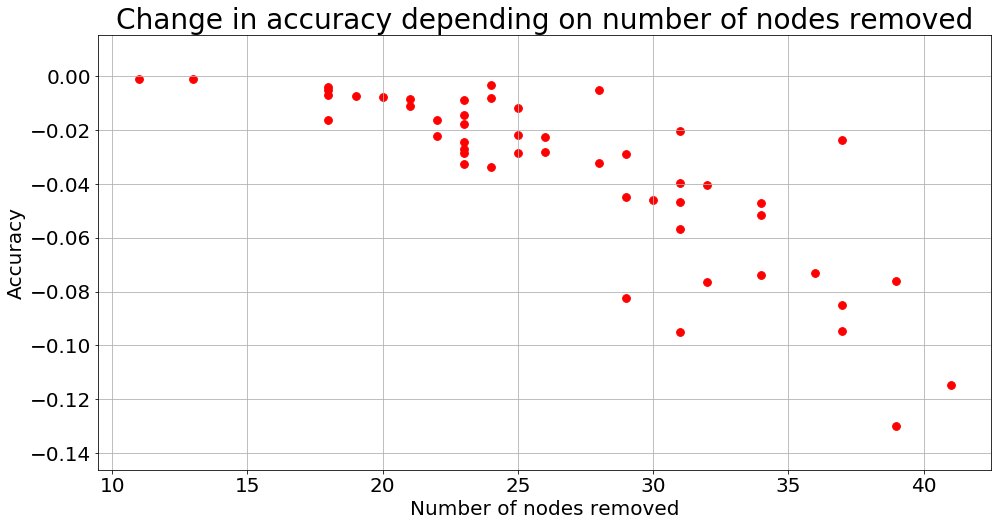

In [31]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_ANN_pre_calc_val_mnist.png")

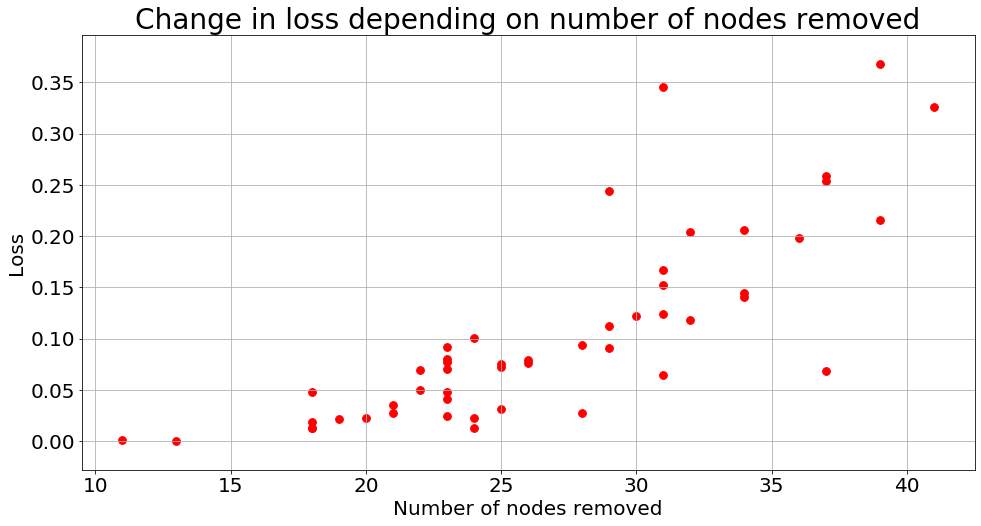

In [32]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_ANN_pre_calc_val_mnist.png")

### Fashion MNIST

#### Set seed

In [33]:
np.random.seed(2020)

In [34]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [35]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
trials = 50
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model, r = models.train_basic_ANN(x_train, y_train, 128, (x_val, y_val), epochs=5)
    tmp_a, tmp_p = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
    num_rem += [tmp_a[0][0] + tmp_a[0][1]]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:51<00:00, 16.62s/it]


In [37]:
NR = pd.Series(num_rem)
NR.to_csv('../../../results/num_removed_ANN_pre_calc_val_fmnist.csv')
NR.describe()

count    50.000000
mean     42.380000
std       8.327211
min      21.000000
25%      37.250000
50%      42.000000
75%      49.000000
max      61.000000
dtype: float64

In [38]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_ANN_pre_calc_val_fmnist.csv')
A.describe()

count    50.000000
mean     -0.065558
std       0.042402
min      -0.188500
25%      -0.082700
50%      -0.060200
75%      -0.038650
max      -0.001100
dtype: float64

In [39]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_ANN_pre_calc_val_fmnist.csv')
L.describe()

count    50.000000
mean      0.155775
std       0.103470
min       0.002618
25%       0.087260
50%       0.131329
75%       0.207014
max       0.521778
dtype: float64

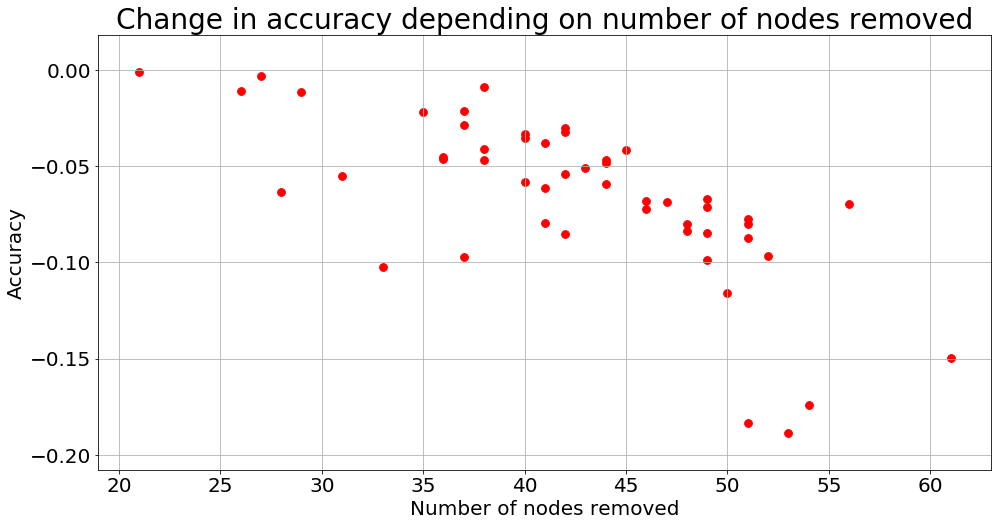

In [40]:
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_ANN_pre_calc_val_fmnist.png")

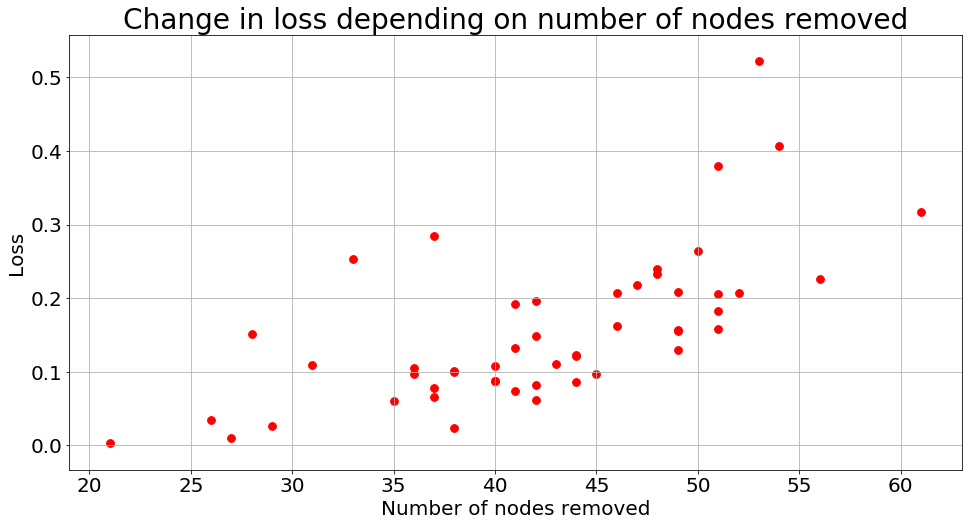

In [41]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_ANN_pre_calc_val_fmnist.png")

## Multi-layer Perceptron

### MNIST

#### Set seed

In [42]:
np.random.seed(2020)

In [43]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [44]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
trials = 50
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [32, 64, 128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    
    tmp_a, tmp_p = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
    
    tmp_rem = []
    
    for (nz, nw, _) in tmp_a:
        tmp_rem += [nz + nw]
    
    num_rem += [tmp_rem]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [19:00<00:00, 22.81s/it]


In [46]:
NR = pd.DataFrame(num_rem, columns=["Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_MLP_pre_calc_val_mnist.csv')
NR.describe()

,Layer 3,Layer 2,Layer 1
count,50.000000,50.000000,50.000000
mean,6.520000,17.060000,33.640000
std,1.865257,4.022437,6.638662
min,1.000000,4.000000,16.000000
25%,6.000000,15.000000,30.250000
50%,7.000000,17.000000,33.500000
75%,7.750000,20.000000,39.750000
max,10.000000,25.000000,44.000000


In [47]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_MLP_pre_calc_val_mnist.csv')
A.describe()

count    50.000000
mean     -0.183746
std       0.106430
min      -0.463900
25%      -0.260600
50%      -0.182950
75%      -0.115375
max      -0.004100
dtype: float64

In [48]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_MLP_pre_calc_val_mnist.csv')
L.describe()

count    50.000000
mean      0.623226
std       0.412628
min       0.005874
25%       0.322745
50%       0.605465
75%       0.845708
max       1.932118
dtype: float64

In [49]:
num_rem = [sum(rem) for rem in num_rem]

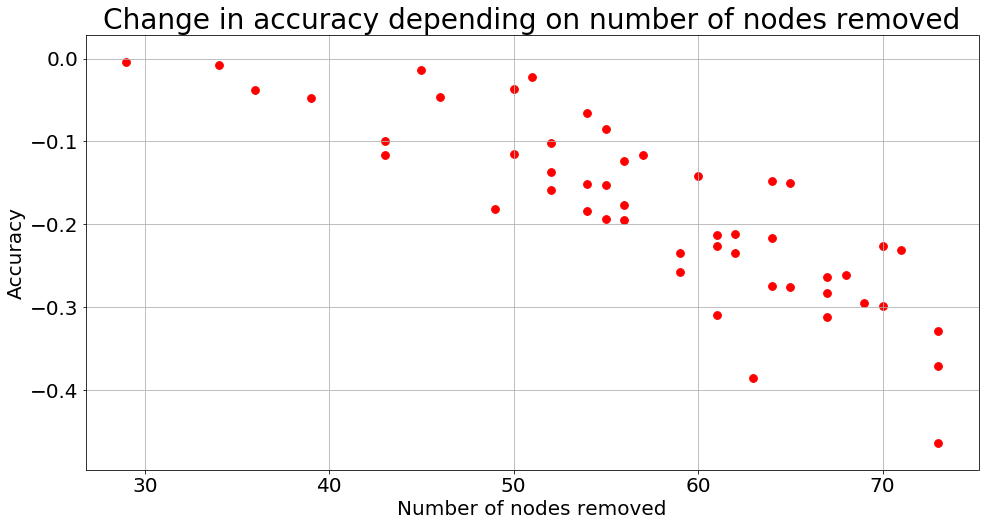

In [50]:
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_MLP_pre_calc_val_mnist.png")

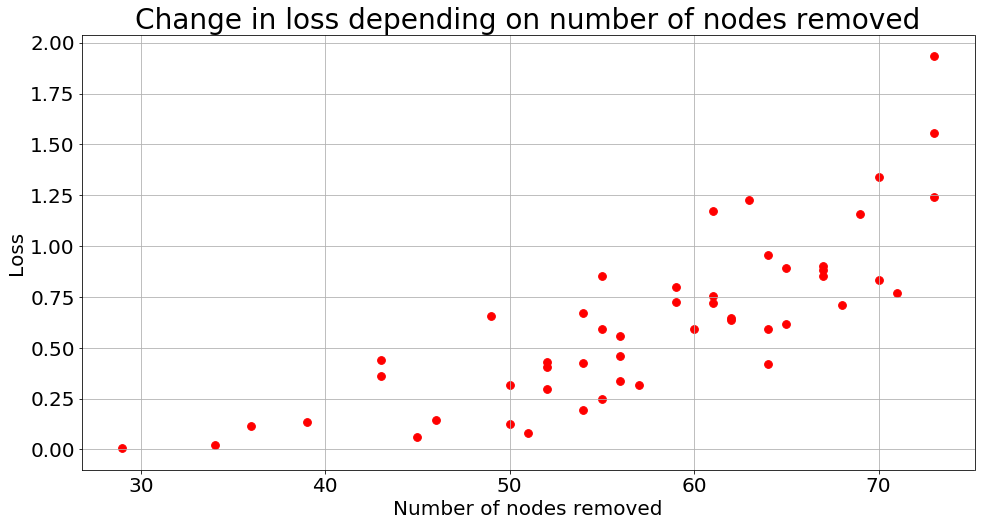

In [51]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_MLP_pre_calc_val_mnist.png")

### Fashion MNIST

#### Set seed

In [52]:
np.random.seed(2020)

In [53]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [54]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [55]:
trials = 50
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [32, 64, 128]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    
    tmp_a, tmp_p = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
    tmp_rem = []
    
    for (nz, nw, _) in tmp_a:
        tmp_rem += [nz + nw]
    
    num_rem += [tmp_rem]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [19:11<00:00, 23.02s/it]


In [56]:
NR = pd.DataFrame(num_rem, columns=["Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_MLP_pre_calc_val_fmnist.csv')
NR.describe()

,Layer 3,Layer 2,Layer 1
count,50.000000,50.000000,50.000000
mean,7.500000,20.400000,46.100000
std,2.484647,4.607004,7.002186
min,2.000000,8.000000,27.000000
25%,6.000000,18.000000,44.000000
50%,8.000000,20.500000,47.500000
75%,9.000000,23.000000,50.000000
max,13.000000,28.000000,58.000000


In [57]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_MLP_pre_calc_val_fmnist.csv')
A.describe()

count    50.000000
mean     -0.174418
std       0.098316
min      -0.455800
25%      -0.237975
50%      -0.166950
75%      -0.098650
max      -0.003600
dtype: float64

In [58]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_MLP_pre_calc_val_fmnist.csv')
L.describe()

count    50.000000
mean      0.515909
std       0.295515
min       0.017387
25%       0.261011
50%       0.540482
75%       0.700906
max       1.244441
dtype: float64

In [59]:
num_rem = [sum(rem) for rem in num_rem]

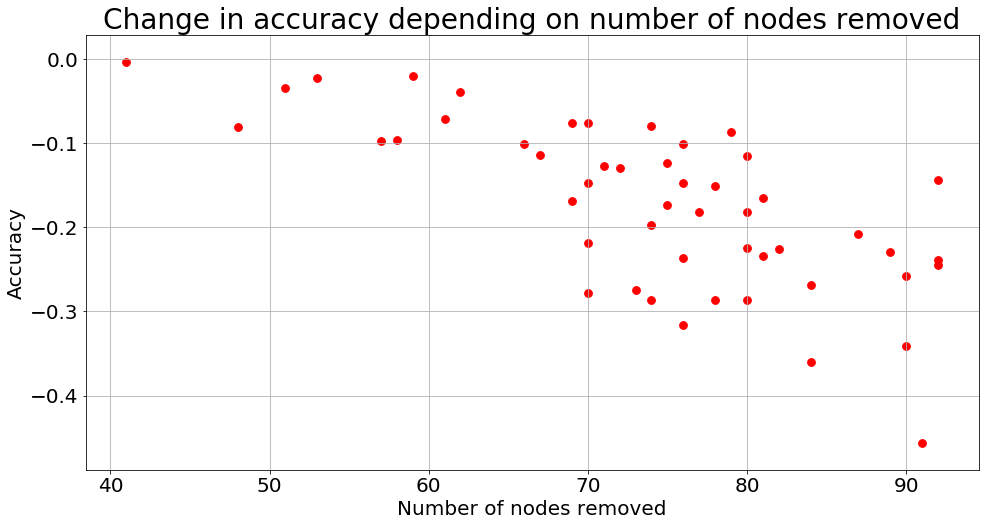

In [60]:
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_MLP_pre_calc_val_fmnist.png")

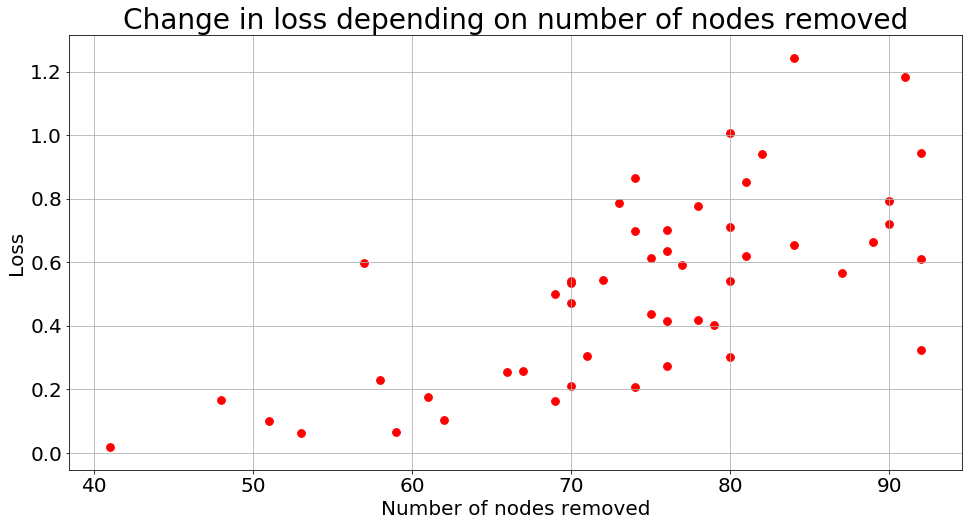

In [61]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_MLP_pre_calc_val_fmnist.png")

## Convolutional Neural Network

### MNIST

#### Set seed

In [62]:
np.random.seed(2020)

In [63]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [64]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [65]:
trials = 10
low_tol = -1e-5
high_tol = 1e-5
conv_layer_sizes = [256, 128, 64, 32]
dense_layer_sizes = [64]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    
    tmp_a, tmp_p = estimate_node_importance_conv(model, tester_model, dense_layer_sizes, conv_layer_sizes, low_tol, high_tol, x_val, y_val)
    
    tmp_rem = []
    
    for (nz, nw, _) in tmp_a:
        tmp_rem += [nz + nw]
    
    num_rem += [tmp_rem]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:10<00:00, 79.04s/it]


In [66]:
NR = pd.DataFrame(num_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_CNN_pre_calc_val_mnist.csv')
NR.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.00000,10.000000,10.000000
mean,41.400000,179.800000,67.20000,29.300000,18.000000
std,4.168666,14.250146,6.89283,3.020302,2.260777
min,35.000000,158.000000,59.00000,24.000000,16.000000
25%,38.500000,166.750000,60.75000,27.250000,17.000000
50%,41.000000,182.500000,66.50000,30.000000,18.000000
75%,44.500000,192.750000,73.75000,31.000000,18.000000
max,48.000000,195.000000,76.00000,33.000000,24.000000


In [67]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_CNN_pre_calc_val_mnist.csv')
A.describe()

count    10.000000
mean     -0.488760
std       0.191912
min      -0.814000
25%      -0.616950
50%      -0.512050
75%      -0.325200
max      -0.199700
dtype: float64

In [68]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_CNN_pre_calc_val_mnist.csv')
L.describe()

count    10.000000
mean      1.604827
std       0.227030
min       1.163363
25%       1.471086
50%       1.595298
75%       1.749894
max       1.925847
dtype: float64

In [69]:
num_rem = [sum(rem) for rem in num_rem]

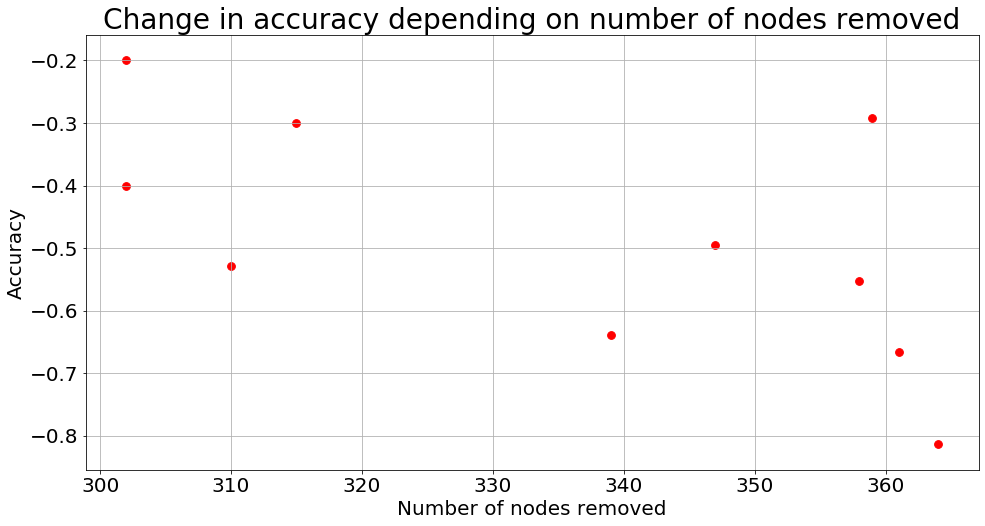

In [70]:
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_CNN_pre_calc_val_mnist.png")

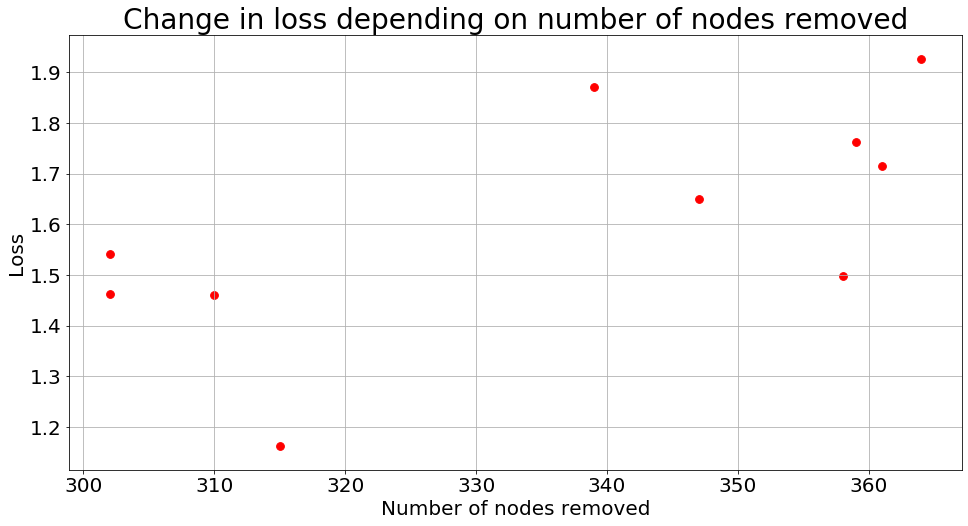

In [71]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_CNN_pre_calc_val_mnist.png")

### Fashion MNIST

#### Set seed

In [72]:
np.random.seed(2020)

In [73]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [74]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [75]:
trials = 10
low_tol = -1e-5
high_tol = 1e-5
conv_layer_sizes = [256, 128, 64, 32]
dense_layer_sizes = [64]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    
    tmp_a, tmp_p = estimate_node_importance_conv(model, tester_model, dense_layer_sizes, conv_layer_sizes, low_tol, high_tol, x_val, y_val)
    tmp_rem = []
    
    for (nz, nw, _) in tmp_a:
        tmp_rem += [nz + nw]
    
    num_rem += [tmp_rem]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:05<00:00, 78.57s/it]


In [76]:
NR = pd.DataFrame(num_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_CNN_pre_calc_val_fmnist.csv')
NR.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,39.300000,168.000000,56.300000,24.200000,11.800000
std,3.093003,15.143756,6.307843,4.779586,3.765339
min,34.000000,136.000000,43.000000,17.000000,4.000000
25%,39.250000,162.000000,53.750000,21.500000,11.000000
50%,40.000000,168.000000,57.000000,23.500000,11.500000
75%,40.750000,176.000000,60.750000,26.000000,14.750000
max,44.000000,193.000000,64.000000,32.000000,16.000000


In [77]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_CNN_pre_calc_val_fmnist.csv')
A.describe()

count    10.000000
mean     -0.224130
std       0.101572
min      -0.407000
25%      -0.293550
50%      -0.208150
75%      -0.162400
max      -0.067900
dtype: float64

In [78]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_CNN_pre_calc_val_fmnist.csv')
L.describe()

count    10.000000
mean      0.920438
std       0.285395
min       0.376125
25%       0.784653
50%       0.958130
75%       1.079699
max       1.340589
dtype: float64

In [79]:
num_rem = [sum(rem) for rem in num_rem]

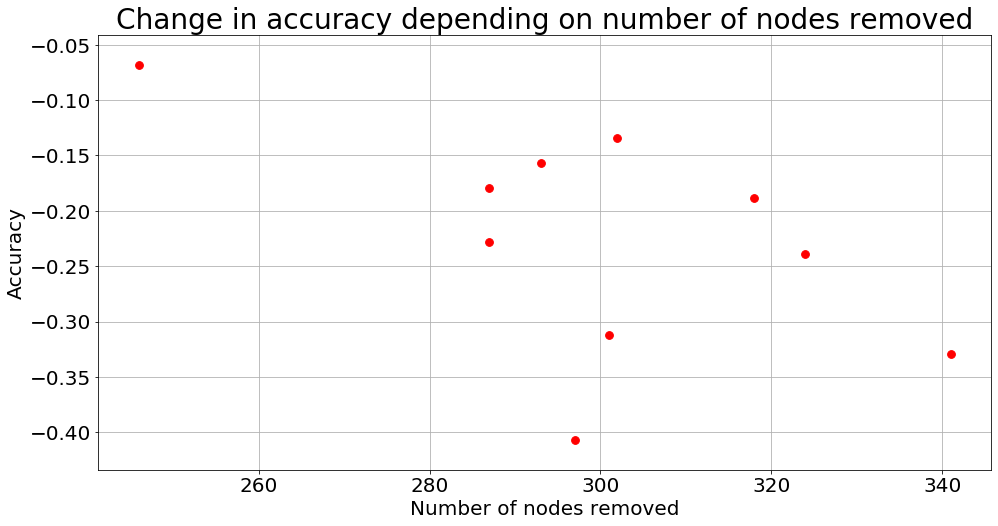

In [80]:
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_CNN_pre_calc_val_fmnist.png")

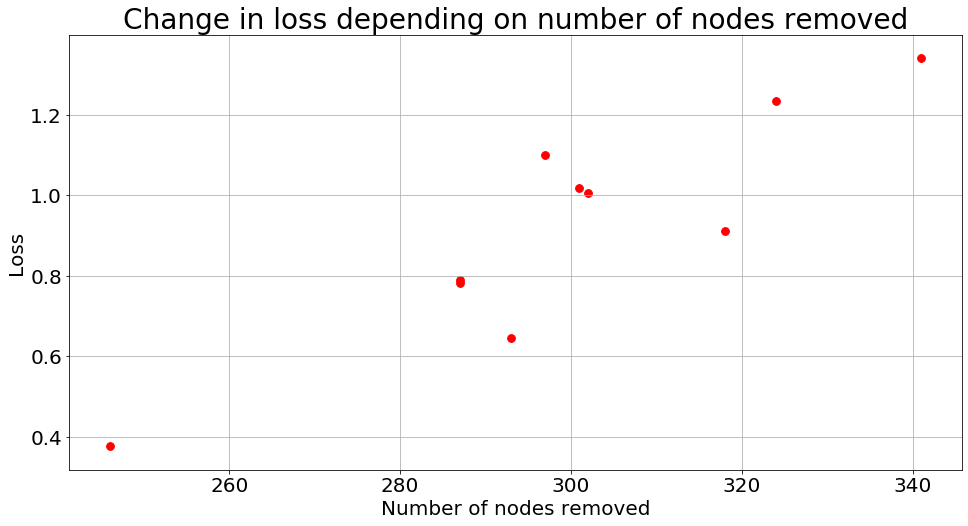

In [81]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_CNN_pre_calc_val_fmnist.png")

### CIFAR10

#### Set seed

In [82]:
np.random.seed(2020)

In [83]:
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [84]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [85]:
trials = 10
low_tol = -1e-5
high_tol = 1e-5
conv_layer_sizes = [256, 128, 64, 32]
dense_layer_sizes = [64]
num_rem = []
delta_accs = []
delta_losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    
    tmp_a, tmp_p = estimate_node_importance_conv(model, tester_model, dense_layer_sizes, conv_layer_sizes, low_tol, high_tol, x_val, y_val)
    tmp_rem = []
    
    for (nz, nw, _) in tmp_a:
        tmp_rem += [nz + nw]
    
    num_rem += [tmp_rem]
    weights = model.get_weights()
    weights = remove_nodes(weights, tmp_p)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    tester_model.set_weights(weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs += [na - a]
    delta_losses += [nl - l]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [18:05<00:00, 108.58s/it]


In [86]:
NR = pd.DataFrame(num_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
NR.to_csv('../../../results/num_removed_CNN_pre_calc_val_cifar.csv')
NR.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,45.300000,155.900000,53.000000,21.900000,5.700000
std,4.137901,8.359293,6.036923,4.306326,1.828782
min,39.000000,142.000000,46.000000,12.000000,1.000000
25%,42.000000,150.250000,49.000000,20.500000,5.250000
50%,46.000000,154.500000,50.500000,22.500000,6.000000
75%,47.000000,162.500000,55.500000,24.000000,7.000000
max,53.000000,168.000000,65.000000,28.000000,7.000000


In [87]:
A = pd.Series(delta_accs)
A.to_csv('../../../results/change_accuracy_CNN_pre_calc_val_cifar.csv')
A.describe()

count    10.000000
mean     -0.250470
std       0.126637
min      -0.420900
25%      -0.366975
50%      -0.232750
75%      -0.136800
max      -0.105900
dtype: float64

In [88]:
L = pd.Series(delta_losses)
L.to_csv('../../../results/chnage_loss_CNN_pre_calc_val_cifar.csv')
L.describe()

count    10.000000
mean      0.813695
std       0.459848
min       0.283914
25%       0.423975
50%       0.712569
75%       1.192677
max       1.541575
dtype: float64

In [89]:
num_rem = [sum(rem) for rem in num_rem]

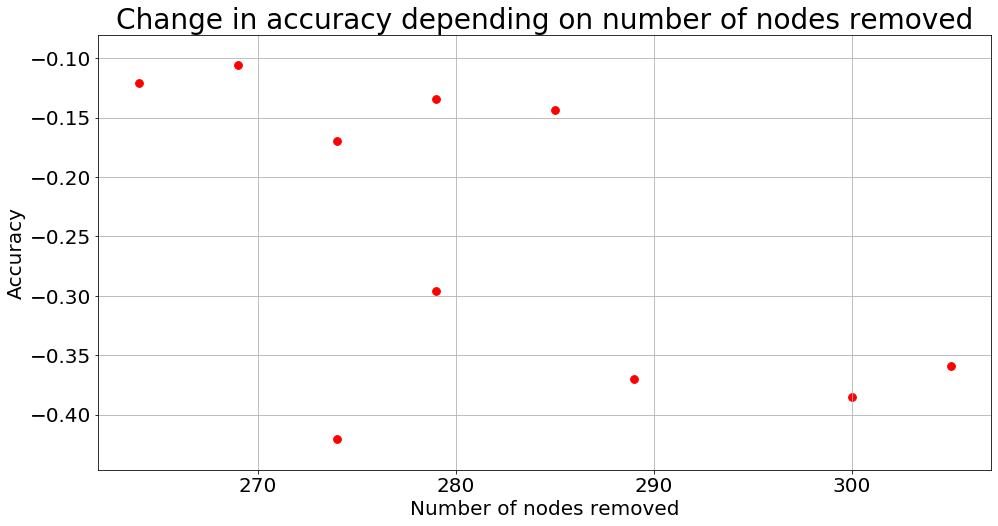

In [90]:
plt.scatter(x=num_rem, y=delta_accs, marker='o', color='red', s=60)
plt.title("Change in accuracy depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_accuracy_vs_nodes_removed_CNN_pre_calc_val_cifar.png")

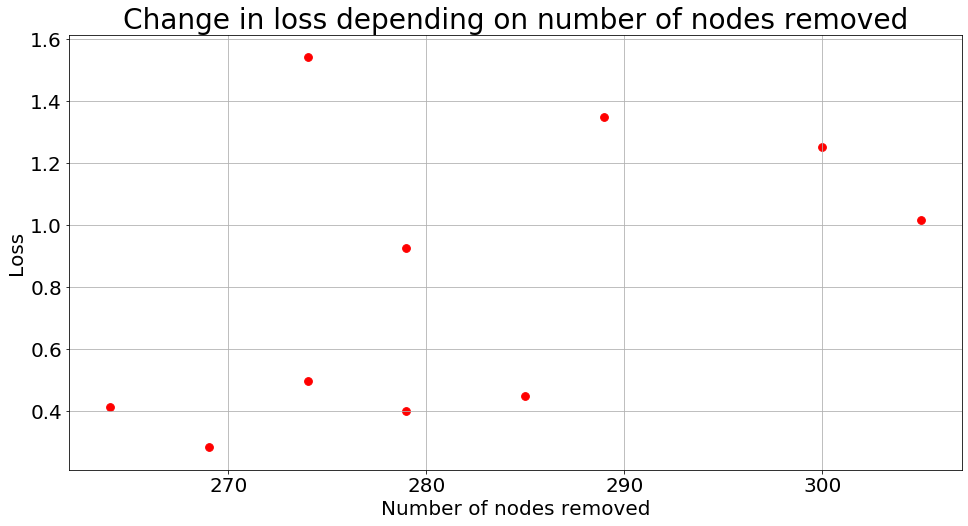

In [91]:
plt.scatter(x=num_rem, y=delta_losses, marker='o', color='red', s=60)
plt.title("Change in loss depending on number of nodes removed", size=28)
plt.xlabel("Number of nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/change_loss_vs_nodes_removed_CNN_pre_calc_val_cifar.png")